In [ ]:
%pip install torch numpy torchvision matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [45]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from torchvision.datasets import Flowers102
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.ops import DeformConv2d
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import ConcatDataset, random_split
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

In [ ]:
# Define the directory path
models_dir = "saved_models"

# Create the directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

In [2]:
classes = [
        "pink primrose",
        "hard-leaved pocket orchid",
        "canterbury bells",
        "sweet pea",
        "english marigold",
        "tiger lily",
        "moon orchid",
        "bird of paradise",
        "monkshood",
        "globe thistle",
        "snapdragon",
        "colt's foot",
        "king protea",
        "spear thistle",
        "yellow iris",
        "globe-flower",
        "purple coneflower",
        "peruvian lily",
        "balloon flower",
        "giant white arum lily",
        "fire lily",
        "pincushion flower",
        "fritillary",
        "red ginger",
        "grape hyacinth",
        "corn poppy",
        "prince of wales feathers",
        "stemless gentian",
        "artichoke",
        "sweet william",
        "carnation",
        "garden phlox",
        "love in the mist",
        "mexican aster",
        "alpine sea holly",
        "ruby-lipped cattleya",
        "cape flower",
        "great masterwort",
        "siam tulip",
        "lenten rose",
        "barbeton daisy",
        "daffodil",
        "sword lily",
        "poinsettia",
        "bolero deep blue",
        "wallflower",
        "marigold",
        "buttercup",
        "oxeye daisy",
        "common dandelion",
        "petunia",
        "wild pansy",
        "primula",
        "sunflower",
        "pelargonium",
        "bishop of llandaff",
        "gaura",
        "geranium",
        "orange dahlia",
        "pink-yellow dahlia?",
        "cautleya spicata",
        "japanese anemone",
        "black-eyed susan",
        "silverbush",
        "californian poppy",
        "osteospermum",
        "spring crocus",
        "bearded iris",
        "windflower",
        "tree poppy",
        "gazania",
        "azalea",
        "water lily",
        "rose",
        "thorn apple",
        "morning glory",
        "passion flower",
        "lotus",
        "toad lily",
        "anthurium",
        "frangipani",
        "clematis",
        "hibiscus",
        "columbine",
        "desert-rose",
        "tree mallow",
        "magnolia",
        "cyclamen",
        "watercress",
        "canna lily",
        "hippeastrum",
        "bee balm",
        "ball moss",
        "foxglove",
        "bougainvillea",
        "camellia",
        "mallow",
        "mexican petunia",
        "bromelia",
        "blanket flower",
        "trumpet creeper",
        "blackberry lily",
    ]

In [3]:
num_classes = len(classes)
batch_size = 64
num_epochs = 50
input_size = 224
mixup = v2.MixUp(alpha=0.1, num_classes=num_classes)

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #mean and std dev values for each channel from ImageNet (pretrain data)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #mean and std dev values for each channel from ImageNet (pretrain data)
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #mean and std dev values for each channel from ImageNet (pretrain data)
    ]),
}

In [5]:
flower_datasets = {}
for split in ['train', 'val', 'test']:
    flower_datasets[split] = Flowers102(
        root='./data',
        split=split,
        download=True,
    )
generator = torch.Generator(device=device)


100%|██████████| 345M/345M [01:07<00:00, 5.09MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.11MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 30.2MB/s]


In [6]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



In [19]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_mixup=False, use_tripleloss=False):
    if use_mixup and use_tripleloss:
        raise ValueError("Mixup cannot be used with a triple-loss model")
    early_stopper = EarlyStopper(patience=5, min_delta=0.001)
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            data_iter = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch}", leave=True)

            for inputs, labels in data_iter:
                inputs = inputs.to(device)
                labels = labels.to(device)
                if phase == 'train' and use_mixup:
                    inputs, labels = mixup(inputs, labels)

                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if use_tripleloss:
                        logits, embeddings = outputs
                        loss = criterion(embeddings, logits, labels)
                    else:
                        logits = outputs
                        loss = criterion(logits, labels)

                    _, preds = torch.max(logits, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                if phase == 'train' and use_mixup:  # convert soft labels from mixup (one-hot) to hard label
                    hard_labels = torch.argmax(labels, dim=1)
                else:  # labels are already hard labels
                    hard_labels = labels
                running_corrects += torch.sum(preds == hard_labels).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
            else:
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

        print()
        # if phase == 'val' and early_stopper.early_stop(epoch_loss):
        #     print(f"Early stopping triggered at epoch {epoch}")
        #     break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return (model, (train_loss_history, train_acc_history, val_loss_history, val_acc_history))


In [8]:
def plot_training_history(history):
    """
    Plots training and validation loss and accuracy over epochs.

    Args:
        history (tuple): A tuple containing four lists:
                         (train_loss_history, train_acc_history, val_loss_history, val_acc_history)
    """
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = history
    epochs = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss_history, 'r-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    if train_acc_history and val_acc_history:
      # Plot Accuracy
      plt.subplot(1, 2, 2)
      plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
      plt.plot(epochs, val_acc_history, 'r-', label='Validation Accuracy')
      plt.title('Accuracy over Epochs')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
def freeze_param(model):
    for param in model.parameters():
        param.requires_grad = False

def get_optimiser(model, learning_rate=0.001):
    params_to_update = []
    for param in model.parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return optim.Adam(params_to_update, lr=learning_rate)

In [10]:
def compute_new_padding(original_padding, kernel_size, dilation_rate):
    """
    Compute the new padding using the formula:
        new_padding = original_padding + ((kernel_size - 1) * (dilation_rate - 1)) // 2
    This ensures the output size remains unchanged.

    Args:
        original_padding (tuple): The original padding (e.g., (p, p)).
        kernel_size (tuple): The kernel size (e.g., (k, k)).
        dilation_rate (int): The dilation rate.

    Returns:
        tuple: New padding for each spatial dimension.
    """
    return tuple(p + ((k - 1) * (dilation_rate - 1)) // 2
                 for p, k in zip(original_padding, kernel_size))

def replace_conv_with_dilated(module, dilation_rate=2):
    """
    Recursively replace all nn.Conv2d layers in the module with a dilated version,
    with padding computed exactly to preserve the output size.

    Args:
        module (nn.Module): The module (or submodule) in which to replace convolutions.
        dilation_rate (int): The dilation rate for the new convolution layers.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            new_padding = compute_new_padding(child.padding, child.kernel_size, dilation_rate)

            new_conv = nn.Conv2d(
                in_channels=child.in_channels,
                out_channels=child.out_channels,
                kernel_size=child.kernel_size,
                stride=child.stride,
                padding=new_padding,   # Precisely computed padding for dilated conv
                dilation=dilation_rate,
                groups=child.groups,
                bias=(child.bias is not None),
                padding_mode=child.padding_mode
            )
            # Copy the weights and bias from the original layer.
            new_conv.weight.data.copy_(child.weight.data)
            if child.bias is not None:
                new_conv.bias.data.copy_(child.bias.data)
            setattr(module, name, new_conv)
        else:
            replace_conv_with_dilated(child, dilation_rate)


In [11]:
class DeformableConv2dWrapper(nn.Module):
    """
    Wraps a standard Conv2d layer to a deformable convolution.
    It creates an offset prediction branch and applies DeformConv2d.
    """
    def __init__(self, conv: nn.Conv2d):
        super(DeformableConv2dWrapper, self).__init__()
        # Save original conv parameters
        self.in_channels = conv.in_channels
        self.out_channels = conv.out_channels
        self.kernel_size = conv.kernel_size
        self.stride = conv.stride
        self.padding = conv.padding
        self.dilation = conv.dilation
        self.groups = conv.groups
        self.has_bias = conv.bias is not None

        # Create an offset conv layer to predict offsets.
        # The number of offset channels equals 2 * (kernel_height * kernel_width)
        self.offset_conv = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=2 * self.kernel_size[0] * self.kernel_size[1],
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            bias=True  # offsets typically include bias
        )

        # Create the deformable convolution layer
        self.deform_conv = DeformConv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups,
            bias=self.has_bias
        )

        # Initialize deform_conv with the original conv weights
        self.deform_conv.weight.data.copy_(conv.weight.data)
        if self.has_bias:
            self.deform_conv.bias.data.copy_(conv.bias.data)

    def forward(self, x):
        # Compute the offsets from the input feature map
        offset = self.offset_conv(x)
        # Apply deformable convolution using the computed offsets
        out = self.deform_conv(x, offset)
        return out

def replace_conv_with_deformable(module, p=0.05):
    """
    Recursively traverse the module and replace all nn.Conv2d layers
    with the deformable convolution wrapper.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            if random.random() < p:
                # Replace the conv layer with our deformable conv wrapper.
                deform_conv_wrapper = DeformableConv2dWrapper(child)
                setattr(module, name, deform_conv_wrapper)
        else:
            replace_conv_with_deformable(child,p)

In [28]:
def sample_triplets(embeddings, labels):
    """
    Forms triplets (anchor, positive, negative) from a batch.

    Args:
        embeddings (Tensor): Embeddings of shape [batch_size, embed_dim].
        labels (Tensor): Labels of shape [batch_size] (hard labels).

    Returns:
        Tuple of Tensors: (anchor, positive, negative)
    """
    anchor_list, positive_list, negative_list = [], [], []
    labels_np = labels.cpu().numpy()

    for i in range(len(labels_np)):
        # Get indices of all samples with the same class as anchor (excluding itself)
        same_class = [j for j in range(len(labels_np)) if labels_np[j] == labels_np[i] and j != i]
        # Get indices for different classes
        diff_class = [j for j in range(len(labels_np)) if labels_np[j] != labels_np[i]]

        # Skip if there are no valid positives or negatives.
        if len(same_class) == 0 or len(diff_class) == 0:
            continue

        anchor_list.append(embeddings[i])
        pos_idx = np.random.choice(same_class)
        neg_idx = np.random.choice(diff_class)
        positive_list.append(embeddings[pos_idx])
        negative_list.append(embeddings[neg_idx])

    if len(anchor_list) == 0:
        return None, None, None
    anchor = torch.stack(anchor_list)
    positive = torch.stack(positive_list)
    negative = torch.stack(negative_list)
    return anchor, positive, negative


class CombinedLoss(nn.Module):
    def __init__(self, weight=0.5, margin=1.0):
        """
        Args:
            ce_weight (float): Weight for the cross entropy loss.
            triplet_weight (float): Weight for the triplet margin loss.
            margin (float): Margin for the triplet loss.
        """
        super(CombinedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.triplet_loss = nn.TripletMarginLoss(margin=margin)
        self.weight = weight

    def forward(self, embeddings, logits, labels):
        """
        Args:
            logits (Tensor): Classification logits output from the classifier head. Shape: [batch_size, num_classes]
            labels (Tensor): Ground truth labels for classification. Shape: [batch_size]
            anchor (Tensor): Anchor embeddings. Shape: [batch_size, embed_dim]
            positive (Tensor): Positive embeddings (from same class as anchor). Shape: [batch_size, embed_dim]
            negative (Tensor): Negative embeddings (from a different class). Shape: [batch_size, embed_dim]

        Returns:
            Tensor: The combined loss value.
        """
        loss_ce = self.ce_loss(logits, labels)
        anchor, positive, negative = sample_triplets(embeddings, labels)
        if anchor is None or positive is None or negative is None:
            loss_triplet = 0.0
        else:
            loss_triplet = self.triplet_loss(anchor, positive, negative)
        combined_loss = self.weight * loss_ce + (1-self.weight) * loss_triplet
        return combined_loss

def make_triple_loss_model(base_model):
    """
    Wraps the base DenseNet model so that its forward pass returns both
    the classification logits and the final feature vector (embedding).

    The feature vector is taken as the output after the global average pooling,
    i.e. just before the final classifier.

    Args:
        base_model (nn.Module): The DenseNet model whose classifier has already
            been replaced to match the desired number of classes.

    Returns:
        nn.Module: A new model that returns a tuple (logits, embeddings).
    """
    class DenseNetTripleWrapper(nn.Module):
        def __init__(self, base_model):
            super(DenseNetTripleWrapper, self).__init__()
            self.base_model = base_model

        @property
        def classifier(self):
            # Expose the classifier from the base model
            return self.base_model.classifier

        def forward(self, x):
            # Extract features using the DenseNet features module.
            features = self.base_model.features(x)
            # Apply ReLU activation (as done in DenseNet's forward)
            out = F.relu(features, inplace=True)
            # Global average pooling to get a fixed-size feature vector.
            out = F.adaptive_avg_pool2d(out, (1, 1))
            # Flatten the pooled features into a vector.
            embeddings = torch.flatten(out, 1)
            # Get the classification logits using the classifier.
            logits = self.base_model.classifier(embeddings)
            # Return both the logits and the embeddings.
            return logits, embeddings

    return DenseNetTripleWrapper(base_model)


In [13]:
def initialize_model(depth, feature_extract=False, num_classes=102, use_pretrained=True, conv_type="standard", dilation_rate=2, deformable_prob=1, triple_loss=False):
    """
    Initialize a DenseNet model with varying depth, convolution type, and optionally a dual-head architecture for triplet loss.

    Args:
        depth (int): One of 121, 161, 169, or 201.
        feature_extract (bool): If True, freeze all layers except the classifier (only used for standard conv).
        num_classes (int): Number of output classes.
        use_pretrained (bool): Whether to load pretrained weights.
        conv_type (str): Convolution type ("standard", "dilated", or "deformable").
        dilation_rate (int): Dilation rate if conv_type is "dilated".
        triple_loss (bool): If True, create same model that outputs both embeddings and logits.

    Returns:
        model: The modified DenseNet model.
    """
    model = None

    if depth == 121:
        model = models.densenet121(pretrained=use_pretrained)
    elif depth == 161:
        model = models.densenet161(pretrained=use_pretrained)
    elif depth == 169:
        model = models.densenet169(pretrained=use_pretrained)
    elif depth == 201:
        model = models.densenet201(pretrained=use_pretrained)
    else:
        raise ValueError("Invalid model depth: {}. Supported depths are 121, 161, 169, and 201.".format(depth))

    feature_extracting = False
    if conv_type.lower() == "standard" and not triple_loss:
        feature_extracting = feature_extract
    if feature_extracting:
        freeze_param(model)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)

    # Modify convolution layers based on conv_type.
    if conv_type.lower() == "dilated":
        replace_conv_with_dilated(model, dilation_rate=dilation_rate)
    elif conv_type.lower() == "deformable":
        random.seed(42)
        replace_conv_with_deformable(model, p=deformable_prob)
    elif conv_type.lower() == "standard":
        pass  # No modifications
    else:
        raise ValueError("Invalid convolution type: {}. Supported types are 'standard', 'dilated', and 'deformable'.".format(conv_type))

    if triple_loss:
        model = make_triple_loss_model(model)

    return model

In [ ]:
# ------------------- Phase 1: 5-Fold Cross Validation for Network Depth Selection -------------------

# Candidate DenseNet depths to evaluate
candidate_depths = [121, 161, 169, 201]
cv_epochs = num_epochs  # Number of epochs to train on each fold (adjust as needed)

# Use the already created 'flower_datasets' dictionary.
# We'll use the 'train' split for cross-validation.
train_dataset = flower_datasets['train']

# Extract all labels for stratified splitting
train_labels = [label for _, label in train_dataset]

# Setup stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

cv_results = {}

for depth in candidate_depths:
    fold_errors = []
    fold_accuracies = []
    print(f"\nEvaluating DenseNet-{depth} with 5-Fold Cross Validation")

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_labels)), train_labels)):
        print(f"\nFold {fold+1}")

        # Create training and validation subsets using the provided train_dataset
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)

        train_subset.dataset.transform = data_transforms['train']
        val_subset.dataset.transform = data_transforms['val']

        # Create DataLoaders for the fold; use same generator and batch_size as defined earlier
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, generator=generator)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, generator=generator)
        dataloaders_cv = {'train': train_loader, 'val': val_loader}

        # Initialize the model using feature extraction, standard conv type, and no triple loss
        model_cv = initialize_model(depth=depth, feature_extract=True, conv_type="standard", triple_loss=False)
        model_cv = model_cv.to(device)

        # Set up optimizer and criterion; note that get_optimiser uses feature_extract flag to freeze parameters if needed
        optimizer_cv = get_optimiser(model=model_cv, feature_extract=True)
        criterion_cv = nn.CrossEntropyLoss()

        # Train on this CV fold
        model_cv, hist_cv = train_model(
            model=model_cv,
            dataloaders=dataloaders_cv,
            criterion=criterion_cv,
            optimizer=optimizer_cv,
            num_epochs=cv_epochs,
            use_mixup=False,
            use_tripleloss=False
        )

        # Use the best validation accuracy from this fold (hist_cv[3] holds validation accuracies)
        best_val_acc = max(hist_cv[3])
        fold_error = 1.0 - best_val_acc
        fold_errors.append(fold_error)
        fold_accuracies.append(best_val_acc)

        print(f"Fold {fold+1}: Best Val Acc: {best_val_acc:.4f}, Error: {fold_error:.4f}")

    # Compute the mean error and accuracy for the current network depth
    mean_error = np.mean(fold_errors)
    mean_accuracy = np.mean(fold_accuracies)
    cv_results[depth] = {'mean_error': mean_error, 'mean_accuracy': mean_accuracy}
    print(f"\nDenseNet-{depth} CV Results: Mean Accuracy = {mean_accuracy:.4f}, Mean Error = {mean_error:.4f}")

# Display summary results for all candidate depths
print("\n=== 5-Fold Cross Validation Results for Network Depths ===")
for depth, results in cv_results.items():
    print(f"DenseNet-{depth}: Mean Accuracy = {results['mean_accuracy']:.4f}, Mean Error = {results['mean_error']:.4f}")

# Select the optimal network depth (lowest mean error, or equivalently highest mean accuracy)
optimal_depth = min(cv_results, key=lambda d: cv_results[d]['mean_error'])
print(f"\nOptimal network depth selected: DenseNet-{optimal_depth}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Evaluating DenseNet-121 with 5-Fold Cross Validation

Fold 1


100%|██████████| 30.8M/30.8M [00:00<00:00, 106MB/s]


	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


train Loss: 4.6698 Acc: 0.0380


Val Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


val Loss: 4.1354 Acc: 0.1471

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 3.7268 Acc: 0.3235


Val Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


val Loss: 3.5265 Acc: 0.4657

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 2.9403 Acc: 0.7451


Val Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 2.9711 Acc: 0.6275

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


train Loss: 2.2941 Acc: 0.8836


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 2.5146 Acc: 0.7941

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 1.7724 Acc: 0.9669


Val Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 2.1461 Acc: 0.7941

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 1.3481 Acc: 0.9865


Val Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 1.8561 Acc: 0.8431

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 1.0440 Acc: 0.9865


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 1.6360 Acc: 0.8529

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.8343 Acc: 0.9951


Val Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 1.4708 Acc: 0.8676

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.6595 Acc: 0.9963


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 1.3519 Acc: 0.8725

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.5332 Acc: 0.9951


Val Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 1.2398 Acc: 0.8676

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.4465 Acc: 0.9963


Val Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


val Loss: 1.1549 Acc: 0.8775

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.3765 Acc: 0.9988


Val Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


val Loss: 1.0835 Acc: 0.8676

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.3242 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 1.0404 Acc: 0.8873

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 0.2699 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


val Loss: 0.9852 Acc: 0.8824

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.2358 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.9496 Acc: 0.8775

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.2135 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.9124 Acc: 0.8922

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 0.1879 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.8814 Acc: 0.8775

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.1699 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.8568 Acc: 0.8725

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.1518 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.8385 Acc: 0.8725

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.1349 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.8235 Acc: 0.8824

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.1274 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.8029 Acc: 0.8971

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.1133 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 0.7816 Acc: 0.8922

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


train Loss: 0.1064 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.7681 Acc: 0.8873

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.1000 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.7507 Acc: 0.8824

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0907 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.7323 Acc: 0.8873

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


train Loss: 0.0864 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.7288 Acc: 0.8922

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.0811 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.7138 Acc: 0.9020

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0751 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.7055 Acc: 0.8922

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0714 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.6915 Acc: 0.8922

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.0656 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.6877 Acc: 0.8873

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 0.0620 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.6824 Acc: 0.8922

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


train Loss: 0.0599 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.6710 Acc: 0.9020

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0552 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.6608 Acc: 0.8971

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0516 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.6559 Acc: 0.9020

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.0502 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


val Loss: 0.6505 Acc: 0.8971

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.0468 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.6410 Acc: 0.8971

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0458 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.6401 Acc: 0.8971

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0450 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


val Loss: 0.6362 Acc: 0.8971

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


train Loss: 0.0419 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


val Loss: 0.6319 Acc: 0.8971

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.0404 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.6287 Acc: 0.8922

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0391 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.6186 Acc: 0.8873

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.0377 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.6098 Acc: 0.8971

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0345 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.6018 Acc: 0.9069

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 0.0339 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


val Loss: 0.6041 Acc: 0.8971

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0344 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.6039 Acc: 0.9020

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 0.0320 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


val Loss: 0.6029 Acc: 0.9020

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 0.0306 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


val Loss: 0.5952 Acc: 0.9020

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.0294 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


val Loss: 0.5907 Acc: 0.9020

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.0290 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


val Loss: 0.5887 Acc: 0.9020

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.0284 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.5902 Acc: 0.9020

Training complete in 7m 49s
Best val Acc: 0.906863
Fold 1: Best Val Acc: 0.9069, Error: 0.0931

Fold 2
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


train Loss: 4.7337 Acc: 0.0196


Val Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 4.1602 Acc: 0.1569

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 3.7621 Acc: 0.3150


Val Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


val Loss: 3.5583 Acc: 0.4951

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


train Loss: 2.9755 Acc: 0.7328


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 3.0274 Acc: 0.6373

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 2.3004 Acc: 0.9154


Val Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


val Loss: 2.5775 Acc: 0.7255

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


train Loss: 1.7540 Acc: 0.9657


Val Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 2.2095 Acc: 0.8137

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 1.3505 Acc: 0.9767


Val Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 1.9457 Acc: 0.8382

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 1.0327 Acc: 0.9877


Val Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 1.7306 Acc: 0.8235

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.8047 Acc: 0.9963


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


val Loss: 1.5693 Acc: 0.8676

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.6448 Acc: 0.9963


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 1.4409 Acc: 0.8480

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.5225 Acc: 0.9963


Val Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


val Loss: 1.3460 Acc: 0.8578

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.4341 Acc: 0.9963


Val Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


val Loss: 1.2659 Acc: 0.8578

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


train Loss: 0.3626 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 1.1953 Acc: 0.8676

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.3058 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


val Loss: 1.1498 Acc: 0.8627

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 0.2653 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 1.0952 Acc: 0.8676

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.2352 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


val Loss: 1.0612 Acc: 0.8775

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.2104 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 1.0239 Acc: 0.8775

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 0.1884 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.9941 Acc: 0.8725

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


train Loss: 0.1621 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.9748 Acc: 0.8725

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.1528 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.9545 Acc: 0.8578

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.1363 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.9213 Acc: 0.8775

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


train Loss: 0.1195 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


val Loss: 0.9110 Acc: 0.8725

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.1154 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.8920 Acc: 0.8775

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.1038 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.8786 Acc: 0.8676

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0949 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.8595 Acc: 0.8725

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0897 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.8435 Acc: 0.8725

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0825 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]


val Loss: 0.8340 Acc: 0.8627

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


train Loss: 0.0773 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.8253 Acc: 0.8775

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0729 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


val Loss: 0.8205 Acc: 0.8725

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0695 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


val Loss: 0.8072 Acc: 0.8725

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.0642 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


val Loss: 0.7918 Acc: 0.8725

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 0.0591 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.7847 Acc: 0.8627

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0574 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.7773 Acc: 0.8775

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0560 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.7692 Acc: 0.8775

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0518 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


val Loss: 0.7639 Acc: 0.8627

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.0489 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


val Loss: 0.7539 Acc: 0.8676

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


train Loss: 0.0473 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


val Loss: 0.7490 Acc: 0.8627

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0445 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.7386 Acc: 0.8725

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0428 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 0.7320 Acc: 0.8725

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 0.0404 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.7227 Acc: 0.8775

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 0.0388 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.7247 Acc: 0.8725

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0377 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.7174 Acc: 0.8578

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 0.0361 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.7118 Acc: 0.8775

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 0.0356 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.7078 Acc: 0.8676

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.0326 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.7047 Acc: 0.8775

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0329 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


val Loss: 0.7010 Acc: 0.8676

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0308 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.6956 Acc: 0.8676

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


train Loss: 0.0302 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


val Loss: 0.6887 Acc: 0.8627

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.0297 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


val Loss: 0.6885 Acc: 0.8676

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 0.0281 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.6800 Acc: 0.8725

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0273 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


val Loss: 0.6816 Acc: 0.8725

Training complete in 7m 47s
Best val Acc: 0.877451
Fold 2: Best Val Acc: 0.8775, Error: 0.1225

Fold 3
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 4.6519 Acc: 0.0417


Val Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 4.1228 Acc: 0.1814

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


train Loss: 3.6665 Acc: 0.3811


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 3.5432 Acc: 0.4510

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


train Loss: 2.9044 Acc: 0.7206


Val Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 3.0161 Acc: 0.6275

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 2.2330 Acc: 0.8983


Val Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 2.5771 Acc: 0.6863

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 1.7123 Acc: 0.9620


Val Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 2.2252 Acc: 0.7549

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 1.3144 Acc: 0.9804


Val Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


val Loss: 1.9598 Acc: 0.7745

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 1.0028 Acc: 0.9951


Val Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 1.7606 Acc: 0.7647

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.8048 Acc: 0.9926


Val Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


val Loss: 1.6090 Acc: 0.8137

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.6308 Acc: 0.9951


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 1.4893 Acc: 0.8039

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.5026 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 1.3902 Acc: 0.8137

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.4215 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 1.3208 Acc: 0.8137

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.3526 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


val Loss: 1.2526 Acc: 0.8235

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.3012 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 1.1981 Acc: 0.8235

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.2642 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 1.1625 Acc: 0.8333

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.2260 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


val Loss: 1.1285 Acc: 0.8431

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 0.2057 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 1.0908 Acc: 0.8284

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.1784 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 1.0628 Acc: 0.8284

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.1601 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 1.0342 Acc: 0.8431

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.1409 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 1.0161 Acc: 0.8235

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 0.1289 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 1.0028 Acc: 0.8186

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.1174 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.9848 Acc: 0.8333

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.1066 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.9710 Acc: 0.8333

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.1003 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.9562 Acc: 0.8382

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


train Loss: 0.0937 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


val Loss: 0.9387 Acc: 0.8284

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.0870 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.9254 Acc: 0.8284

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0817 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 0.9148 Acc: 0.8284

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0743 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.9065 Acc: 0.8333

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0694 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 0.8946 Acc: 0.8382

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0660 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.8813 Acc: 0.8333

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


train Loss: 0.0613 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.8746 Acc: 0.8382

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0589 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.8711 Acc: 0.8235

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0559 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.8603 Acc: 0.8333

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


train Loss: 0.0538 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


val Loss: 0.8512 Acc: 0.8333

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0514 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


val Loss: 0.8444 Acc: 0.8480

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0478 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.8409 Acc: 0.8333

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0464 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 0.8327 Acc: 0.8333

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0440 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.8256 Acc: 0.8382

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0425 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.8232 Acc: 0.8480

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


train Loss: 0.0393 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 0.8214 Acc: 0.8333

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0386 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.8161 Acc: 0.8235

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0362 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.8047 Acc: 0.8284

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


train Loss: 0.0370 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


val Loss: 0.8013 Acc: 0.8284

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0346 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


val Loss: 0.7966 Acc: 0.8284

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0329 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 0.7906 Acc: 0.8284

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0323 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.7868 Acc: 0.8284

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0297 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.7812 Acc: 0.8235

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


train Loss: 0.0296 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 0.7805 Acc: 0.8382

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 0.0289 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.7831 Acc: 0.8431

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0272 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


val Loss: 0.7725 Acc: 0.8431

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0262 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 0.7682 Acc: 0.8284

Training complete in 7m 48s
Best val Acc: 0.848039
Fold 3: Best Val Acc: 0.8480, Error: 0.1520

Fold 4
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


train Loss: 4.6657 Acc: 0.0221


Val Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 4.1598 Acc: 0.1667

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 3.6902 Acc: 0.3554


Val Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 3.5620 Acc: 0.3873

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 2.9028 Acc: 0.7708


Val Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 3.0017 Acc: 0.6078

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 2.2641 Acc: 0.8971


Val Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 2.5361 Acc: 0.7010

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 1.7252 Acc: 0.9510


Val Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 2.1851 Acc: 0.7451

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 1.3117 Acc: 0.9890


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 1.8977 Acc: 0.7990

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 1.0028 Acc: 0.9926


Val Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 1.7004 Acc: 0.8039

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.7826 Acc: 0.9902


Val Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 1.5468 Acc: 0.8137

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.6410 Acc: 0.9963


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 1.4150 Acc: 0.8186

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.5116 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


val Loss: 1.3330 Acc: 0.8137

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.4257 Acc: 0.9988


Val Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


val Loss: 1.2507 Acc: 0.8333

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


train Loss: 0.3615 Acc: 0.9975


Val Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 1.1845 Acc: 0.8431

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.3062 Acc: 0.9988


Val Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 1.1398 Acc: 0.8284

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.2621 Acc: 0.9988


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 1.0908 Acc: 0.8480

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


train Loss: 0.2290 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 1.0505 Acc: 0.8284

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.2027 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 1.0291 Acc: 0.8333

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.1840 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.9994 Acc: 0.8333

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.1692 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


val Loss: 0.9731 Acc: 0.8578

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.1520 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.9545 Acc: 0.8431

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


train Loss: 0.1296 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.9289 Acc: 0.8529

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


train Loss: 0.1212 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.9134 Acc: 0.8529

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.1100 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 0.8996 Acc: 0.8529

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.1003 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 0.8886 Acc: 0.8382

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 0.0947 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


val Loss: 0.8716 Acc: 0.8578

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 0.0892 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


val Loss: 0.8565 Acc: 0.8627

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0832 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.8484 Acc: 0.8627

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0760 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.8364 Acc: 0.8578

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0722 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.8244 Acc: 0.8529

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0683 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


val Loss: 0.8159 Acc: 0.8578

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0659 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.8068 Acc: 0.8676

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0616 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.7957 Acc: 0.8676

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0560 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 0.7907 Acc: 0.8627

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 0.0552 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


val Loss: 0.7835 Acc: 0.8676

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0506 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


val Loss: 0.7791 Acc: 0.8627

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.0490 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.7712 Acc: 0.8578

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0465 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.7636 Acc: 0.8725

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0451 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.7573 Acc: 0.8676

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0420 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.7538 Acc: 0.8627

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


train Loss: 0.0411 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.7491 Acc: 0.8529

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0392 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.7406 Acc: 0.8627

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0370 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.7351 Acc: 0.8627

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


train Loss: 0.0373 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


val Loss: 0.7279 Acc: 0.8725

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0341 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 0.7309 Acc: 0.8627

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0336 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.7296 Acc: 0.8578

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0329 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.7201 Acc: 0.8578

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0319 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.7127 Acc: 0.8676

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.0296 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.7117 Acc: 0.8725

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


train Loss: 0.0285 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.7080 Acc: 0.8725

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0277 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.7026 Acc: 0.8676

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0267 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


val Loss: 0.6986 Acc: 0.8627

Training complete in 7m 50s
Best val Acc: 0.872549
Fold 4: Best Val Acc: 0.8725, Error: 0.1275

Fold 5
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 4.7150 Acc: 0.0233


Val Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


val Loss: 4.1491 Acc: 0.1520

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 3.7470 Acc: 0.3100


Val Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


val Loss: 3.5388 Acc: 0.5000

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 2.9735 Acc: 0.7194


Val Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 2.9932 Acc: 0.6373

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 2.3193 Acc: 0.8885


Val Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 2.5433 Acc: 0.6814

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 1.7506 Acc: 0.9547


Val Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 2.1719 Acc: 0.7990

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 1.3459 Acc: 0.9828


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


val Loss: 1.8906 Acc: 0.7794

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 1.0212 Acc: 0.9877


Val Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 1.6905 Acc: 0.8088

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.8233 Acc: 0.9902


Val Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 1.5208 Acc: 0.8431

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.6421 Acc: 0.9975


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 1.4010 Acc: 0.8431

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.5262 Acc: 0.9988


Val Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 1.3049 Acc: 0.8431

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.4329 Acc: 0.9988


Val Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 1.2304 Acc: 0.8431

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


train Loss: 0.3656 Acc: 0.9975


Val Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 1.1672 Acc: 0.8676

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.3166 Acc: 0.9988


Val Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 1.1168 Acc: 0.8529

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.2628 Acc: 0.9988


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 1.0626 Acc: 0.8627

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 0.2311 Acc: 0.9988


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 1.0300 Acc: 0.8725

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.2093 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


val Loss: 1.0038 Acc: 0.8627

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.1895 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


val Loss: 0.9780 Acc: 0.8725

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.1653 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.9465 Acc: 0.8627

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


train Loss: 0.1442 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.9243 Acc: 0.8725

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


train Loss: 0.1360 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.9077 Acc: 0.8676

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.1211 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.8872 Acc: 0.8627

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.1138 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.8696 Acc: 0.8627

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.0986 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.8608 Acc: 0.8725

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.0938 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


val Loss: 0.8455 Acc: 0.8627

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


train Loss: 0.0890 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.8344 Acc: 0.8676

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0824 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 0.8259 Acc: 0.8627

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0787 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.8145 Acc: 0.8676

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0718 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


val Loss: 0.7983 Acc: 0.8725

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


train Loss: 0.0681 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.7944 Acc: 0.8578

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0643 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


val Loss: 0.7853 Acc: 0.8676

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.0599 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.7784 Acc: 0.8676

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0562 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


val Loss: 0.7687 Acc: 0.8578

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 0.0541 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.7629 Acc: 0.8725

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


train Loss: 0.0539 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.7606 Acc: 0.8725

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0490 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.7532 Acc: 0.8676

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0480 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.7472 Acc: 0.8725

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.0463 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


val Loss: 0.7399 Acc: 0.8725

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


train Loss: 0.0431 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.7351 Acc: 0.8725

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0403 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


val Loss: 0.7290 Acc: 0.8775

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0378 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


val Loss: 0.7244 Acc: 0.8725

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


train Loss: 0.0373 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.7179 Acc: 0.8676

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


train Loss: 0.0366 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


val Loss: 0.7140 Acc: 0.8676

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


train Loss: 0.0347 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


val Loss: 0.7073 Acc: 0.8725

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0340 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


val Loss: 0.7089 Acc: 0.8725

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0346 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


val Loss: 0.7080 Acc: 0.8725

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0317 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


val Loss: 0.6985 Acc: 0.8775

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


train Loss: 0.0305 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


val Loss: 0.6997 Acc: 0.8775

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.0285 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.6935 Acc: 0.8725

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0287 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


val Loss: 0.6869 Acc: 0.8725

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


train Loss: 0.0264 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


val Loss: 0.6865 Acc: 0.8775

Training complete in 7m 47s
Best val Acc: 0.877451
Fold 5: Best Val Acc: 0.8775, Error: 0.1225

DenseNet-121 CV Results: Mean Accuracy = 0.8765, Mean Error = 0.1235

Evaluating DenseNet-161 with 5-Fold Cross Validation

Fold 1


100%|██████████| 110M/110M [00:00<00:00, 178MB/s]


	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 4.6274 Acc: 0.0564


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 4.0280 Acc: 0.3088

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 3.4445 Acc: 0.5539


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 3.2539 Acc: 0.6569

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 2.4744 Acc: 0.8922


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 2.6041 Acc: 0.7451

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 1.7288 Acc: 0.9730


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 2.1070 Acc: 0.8235

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 1.1930 Acc: 0.9877


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.7586 Acc: 0.8676

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.8326 Acc: 0.9951


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 1.5134 Acc: 0.8578

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.6082 Acc: 0.9988


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 1.3357 Acc: 0.8873

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.4511 Acc: 0.9988


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.2114 Acc: 0.8725

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.3540 Acc: 0.9988


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


val Loss: 1.1216 Acc: 0.8775

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.2775 Acc: 0.9988


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


val Loss: 1.0559 Acc: 0.8725

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.2259 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


val Loss: 0.9948 Acc: 0.8922

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.1875 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.9538 Acc: 0.8922

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.1606 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.9146 Acc: 0.8922

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1392 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.8859 Acc: 0.8922

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.1233 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.8530 Acc: 0.8922

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.1066 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.8264 Acc: 0.8873

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0958 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.8087 Acc: 0.8971

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0856 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.7883 Acc: 0.8873

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0795 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


val Loss: 0.7741 Acc: 0.8922

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0729 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


val Loss: 0.7657 Acc: 0.8971

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0644 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


val Loss: 0.7468 Acc: 0.8922

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.0599 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


val Loss: 0.7329 Acc: 0.8971

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0556 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.7216 Acc: 0.8971

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0538 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.7097 Acc: 0.8922

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0489 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.7039 Acc: 0.9020

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0452 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6925 Acc: 0.9020

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0427 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.6782 Acc: 0.8971

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0394 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6745 Acc: 0.8922

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0379 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6651 Acc: 0.8971

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0351 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


val Loss: 0.6648 Acc: 0.8922

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.0336 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


val Loss: 0.6563 Acc: 0.8922

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


train Loss: 0.0310 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


val Loss: 0.6502 Acc: 0.8922

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0294 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


val Loss: 0.6423 Acc: 0.8971

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0288 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.6408 Acc: 0.8971

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0274 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6315 Acc: 0.8922

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0266 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6289 Acc: 0.8971

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0256 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6224 Acc: 0.9020

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0234 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6139 Acc: 0.9020

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0234 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.6084 Acc: 0.8971

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0222 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6065 Acc: 0.8971

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0212 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


val Loss: 0.6018 Acc: 0.9020

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0201 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


val Loss: 0.5953 Acc: 0.9020

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0196 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


val Loss: 0.5953 Acc: 0.9020

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0202 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.5934 Acc: 0.8971

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0184 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.5896 Acc: 0.8922

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0176 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.5821 Acc: 0.8971

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0168 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.5800 Acc: 0.9020

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0163 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.5710 Acc: 0.8971

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0155 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.5735 Acc: 0.9020

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0153 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.5671 Acc: 0.8971

Training complete in 10m 57s
Best val Acc: 0.901961
Fold 1: Best Val Acc: 0.9020, Error: 0.0980

Fold 2
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 4.5904 Acc: 0.0527


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 4.0067 Acc: 0.2696

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 3.3831 Acc: 0.5735


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


val Loss: 3.2305 Acc: 0.6618

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 2.4194 Acc: 0.9093


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


val Loss: 2.5912 Acc: 0.7745

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 1.7092 Acc: 0.9694


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


val Loss: 2.1153 Acc: 0.8333

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 1.1537 Acc: 0.9975


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 1.7606 Acc: 0.8529

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.7964 Acc: 0.9988


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 1.5269 Acc: 0.8627

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.5894 Acc: 1.0000


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 1.3607 Acc: 0.8824

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.4353 Acc: 1.0000


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 1.2344 Acc: 0.8873

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.3427 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.1520 Acc: 0.8922

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.2669 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.0798 Acc: 0.8922

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.2194 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 1.0197 Acc: 0.8824

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.1819 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


val Loss: 0.9759 Acc: 0.8922

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.1562 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


val Loss: 0.9437 Acc: 0.8873

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


train Loss: 0.1371 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


val Loss: 0.9103 Acc: 0.8922

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.1165 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


val Loss: 0.8859 Acc: 0.8922

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.1073 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.8585 Acc: 0.8971

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0939 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.8391 Acc: 0.8971

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0845 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.8176 Acc: 0.9069

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0773 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.8020 Acc: 0.8971

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0700 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.7807 Acc: 0.8922

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0640 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.7737 Acc: 0.8922

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0585 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.7592 Acc: 0.8971

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0539 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


val Loss: 0.7476 Acc: 0.8971

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0524 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


val Loss: 0.7392 Acc: 0.8971

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


train Loss: 0.0480 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


val Loss: 0.7208 Acc: 0.8922

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.0454 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


val Loss: 0.7156 Acc: 0.8971

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0421 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.7082 Acc: 0.9020

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0391 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.6988 Acc: 0.8971

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0364 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6903 Acc: 0.9069

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0344 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6867 Acc: 0.8971

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0335 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.6797 Acc: 0.9069

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0322 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6732 Acc: 0.9020

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0294 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.6666 Acc: 0.9069

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0290 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6600 Acc: 0.9020

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0266 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


val Loss: 0.6562 Acc: 0.8971

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0260 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


val Loss: 0.6501 Acc: 0.9020

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0242 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


val Loss: 0.6438 Acc: 0.9020

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0233 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6390 Acc: 0.9069

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0228 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.6337 Acc: 0.9069

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


train Loss: 0.0224 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


val Loss: 0.6345 Acc: 0.9069

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0213 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6297 Acc: 0.9069

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


train Loss: 0.0201 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


val Loss: 0.6265 Acc: 0.9069

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0192 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.6181 Acc: 0.9069

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0182 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


val Loss: 0.6134 Acc: 0.9069

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0185 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


val Loss: 0.6103 Acc: 0.9020

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0178 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


val Loss: 0.6073 Acc: 0.9020

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0163 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6067 Acc: 0.9069

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0167 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.6015 Acc: 0.9069

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0159 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.6029 Acc: 0.9069

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0152 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.5959 Acc: 0.9020

Training complete in 10m 59s
Best val Acc: 0.906863
Fold 2: Best Val Acc: 0.9069, Error: 0.0931

Fold 3
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 4.6027 Acc: 0.0490


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 4.0246 Acc: 0.2745

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 3.4255 Acc: 0.5208


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 3.2578 Acc: 0.6029

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 2.4400 Acc: 0.9020


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 2.6353 Acc: 0.7549

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 1.7078 Acc: 0.9718


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 2.1641 Acc: 0.7990

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 1.1920 Acc: 0.9804


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


val Loss: 1.8178 Acc: 0.8186

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


train Loss: 0.8402 Acc: 0.9926


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


val Loss: 1.5756 Acc: 0.8676

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.6018 Acc: 0.9988


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


val Loss: 1.4222 Acc: 0.8627

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.4530 Acc: 0.9988


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.2907 Acc: 0.8775

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.3555 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.1913 Acc: 0.8725

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.2848 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 1.1214 Acc: 0.8824

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.2303 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.0730 Acc: 0.8922

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1934 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 1.0130 Acc: 0.8873

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.1635 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.9780 Acc: 0.8824

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1459 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.9382 Acc: 0.8922

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1216 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.9117 Acc: 0.8775

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.1085 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


val Loss: 0.8849 Acc: 0.8922

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


train Loss: 0.0960 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


val Loss: 0.8632 Acc: 0.8922

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0881 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


val Loss: 0.8392 Acc: 0.8971

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0781 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.8212 Acc: 0.8971

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0721 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.8072 Acc: 0.8971

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0656 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.7901 Acc: 0.8873

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0613 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.7768 Acc: 0.8971

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0558 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.7649 Acc: 0.8971

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0536 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.7542 Acc: 0.8971

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0489 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.7439 Acc: 0.8873

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0453 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.7282 Acc: 0.8971

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0435 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


val Loss: 0.7177 Acc: 0.9069

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0408 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


val Loss: 0.7088 Acc: 0.9069

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0381 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


val Loss: 0.7019 Acc: 0.9020

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0352 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6939 Acc: 0.9069

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


train Loss: 0.0346 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6905 Acc: 0.8922

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0315 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.6871 Acc: 0.8971

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0307 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6767 Acc: 0.8971

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0294 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6683 Acc: 0.8971

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0289 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6656 Acc: 0.9020

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0262 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6596 Acc: 0.8922

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0252 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


val Loss: 0.6489 Acc: 0.9069

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0247 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


val Loss: 0.6430 Acc: 0.9069

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


train Loss: 0.0240 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


val Loss: 0.6410 Acc: 0.8971

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0223 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


val Loss: 0.6331 Acc: 0.9020

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0215 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6299 Acc: 0.9069

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0203 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6285 Acc: 0.8971

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0204 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6241 Acc: 0.9020

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0200 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6219 Acc: 0.8971

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0187 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6116 Acc: 0.8971

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0180 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.6092 Acc: 0.8971

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0172 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6053 Acc: 0.9069

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0174 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.6030 Acc: 0.8971

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0163 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


val Loss: 0.5973 Acc: 0.8971

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


train Loss: 0.0158 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


val Loss: 0.5948 Acc: 0.9069

Training complete in 10m 58s
Best val Acc: 0.906863
Fold 3: Best Val Acc: 0.9069, Error: 0.0931

Fold 4
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 4.6436 Acc: 0.0355


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


val Loss: 4.0595 Acc: 0.2255

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 3.4763 Acc: 0.5074


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 3.2982 Acc: 0.6373

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 2.5052 Acc: 0.8603


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 2.6688 Acc: 0.7353

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 1.7329 Acc: 0.9645


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 2.1865 Acc: 0.8088

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 1.1999 Acc: 0.9939


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.8370 Acc: 0.8578

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.8355 Acc: 0.9963


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.5986 Acc: 0.8333

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.6031 Acc: 1.0000


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 1.4201 Acc: 0.8480

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.4518 Acc: 1.0000


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


val Loss: 1.2926 Acc: 0.8775

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.3533 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


val Loss: 1.2195 Acc: 0.8529

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.2816 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


val Loss: 1.1445 Acc: 0.8627

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.2300 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


val Loss: 1.0836 Acc: 0.8578

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1894 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 1.0304 Acc: 0.8676

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1611 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.9959 Acc: 0.8676

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1423 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.9735 Acc: 0.8824

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1213 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.9420 Acc: 0.8627

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1058 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.9148 Acc: 0.8578

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


train Loss: 0.0977 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.8958 Acc: 0.8676

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0849 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.8821 Acc: 0.8676

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0782 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


val Loss: 0.8630 Acc: 0.8627

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.0719 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


val Loss: 0.8473 Acc: 0.8627

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0653 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


val Loss: 0.8324 Acc: 0.8676

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0617 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.8180 Acc: 0.8578

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0567 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.8072 Acc: 0.8775

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0523 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.8005 Acc: 0.8775

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0492 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.7924 Acc: 0.8725

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0468 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.7773 Acc: 0.8676

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0425 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.7673 Acc: 0.8676

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0392 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.7571 Acc: 0.8676

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0378 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.7533 Acc: 0.8627

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0354 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


val Loss: 0.7429 Acc: 0.8676

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.0336 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


val Loss: 0.7365 Acc: 0.8676

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


train Loss: 0.0320 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


val Loss: 0.7326 Acc: 0.8775

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0310 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.7296 Acc: 0.8676

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0297 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.7240 Acc: 0.8725

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0274 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.7171 Acc: 0.8725

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0268 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.7186 Acc: 0.8578

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0244 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.7072 Acc: 0.8627

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0234 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.7026 Acc: 0.8725

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0231 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.7004 Acc: 0.8676

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0219 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6931 Acc: 0.8725

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0217 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


val Loss: 0.6923 Acc: 0.8676

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.0209 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


val Loss: 0.6853 Acc: 0.8725

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


train Loss: 0.0189 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


val Loss: 0.6846 Acc: 0.8627

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0198 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


val Loss: 0.6818 Acc: 0.8676

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0188 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6740 Acc: 0.8725

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0176 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6734 Acc: 0.8725

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0178 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6690 Acc: 0.8775

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


train Loss: 0.0165 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


val Loss: 0.6666 Acc: 0.8775

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0161 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6620 Acc: 0.8775

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


train Loss: 0.0154 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


val Loss: 0.6600 Acc: 0.8725

Training complete in 11m 2s
Best val Acc: 0.882353
Fold 4: Best Val Acc: 0.8824, Error: 0.1176

Fold 5
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


train Loss: 4.5808 Acc: 0.0417


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


val Loss: 3.9775 Acc: 0.2598

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 3.4008 Acc: 0.5674


Val Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


val Loss: 3.2008 Acc: 0.6471

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 2.4328 Acc: 0.9130


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 2.5631 Acc: 0.7353

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


train Loss: 1.7048 Acc: 0.9779


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


val Loss: 2.0870 Acc: 0.7843

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


train Loss: 1.1737 Acc: 0.9890


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 1.7372 Acc: 0.8578

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:11<00:00,  1.18it/s]


train Loss: 0.8094 Acc: 0.9939


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 1.5046 Acc: 0.8676

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.5894 Acc: 0.9975


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 1.3342 Acc: 0.8725

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.4452 Acc: 0.9975


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 1.2184 Acc: 0.8824

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.3456 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


val Loss: 1.1217 Acc: 0.8922

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


train Loss: 0.2738 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


val Loss: 1.0489 Acc: 0.8873

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.2237 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


val Loss: 0.9938 Acc: 0.8971

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1883 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


val Loss: 0.9462 Acc: 0.8971

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1581 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.9163 Acc: 0.9020

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s]


train Loss: 0.1349 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.8861 Acc: 0.9118

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1190 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.8516 Acc: 0.8971

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.1051 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.8255 Acc: 0.8922

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


train Loss: 0.0947 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.8042 Acc: 0.8971

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0844 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


val Loss: 0.7885 Acc: 0.9020

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0774 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


val Loss: 0.7705 Acc: 0.9020

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


train Loss: 0.0702 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


val Loss: 0.7554 Acc: 0.9020

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.0646 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


val Loss: 0.7444 Acc: 0.8971

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s]


train Loss: 0.0600 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.7292 Acc: 0.8922

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0542 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.7175 Acc: 0.9069

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0513 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.7083 Acc: 0.9020

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0476 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6951 Acc: 0.9020

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0453 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.6890 Acc: 0.8971

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0412 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.6733 Acc: 0.9020

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0398 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6668 Acc: 0.9069

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0364 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


val Loss: 0.6603 Acc: 0.9118

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.0355 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


val Loss: 0.6566 Acc: 0.9118

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0336 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


val Loss: 0.6502 Acc: 0.8971

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0319 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.6434 Acc: 0.8971

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0305 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6319 Acc: 0.9069

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0289 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.6285 Acc: 0.9069

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


train Loss: 0.0275 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6278 Acc: 0.9069

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0262 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.6250 Acc: 0.9020

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0249 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6161 Acc: 0.9020

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0238 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.6080 Acc: 0.9069

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0236 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


val Loss: 0.6051 Acc: 0.9069

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


train Loss: 0.0230 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


val Loss: 0.6009 Acc: 0.9020

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


train Loss: 0.0211 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


val Loss: 0.5960 Acc: 0.8971

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0197 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.5913 Acc: 0.9020

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0192 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.5872 Acc: 0.8971

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


train Loss: 0.0187 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.5852 Acc: 0.9020

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0181 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.5853 Acc: 0.9020

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0169 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.5768 Acc: 0.9069

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0168 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.5709 Acc: 0.9118

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0161 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.5701 Acc: 0.9069

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0161 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


val Loss: 0.5612 Acc: 0.9069

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


train Loss: 0.0155 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


val Loss: 0.5630 Acc: 0.9069

Training complete in 11m 3s
Best val Acc: 0.911765
Fold 5: Best Val Acc: 0.9118, Error: 0.0882

DenseNet-161 CV Results: Mean Accuracy = 0.9020, Mean Error = 0.0980

Evaluating DenseNet-169 with 5-Fold Cross Validation

Fold 1


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 165MB/s]


	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 4.6183 Acc: 0.0343


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


val Loss: 4.0054 Acc: 0.2647

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 3.4300 Acc: 0.4755


Val Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 3.2253 Acc: 0.6324

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 2.4544 Acc: 0.8603


Val Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


val Loss: 2.5785 Acc: 0.7500

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 1.7341 Acc: 0.9571


Val Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 2.0900 Acc: 0.7990

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 1.2020 Acc: 0.9890


Val Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 1.7309 Acc: 0.8235

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


train Loss: 0.8501 Acc: 0.9914


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


val Loss: 1.4996 Acc: 0.8235

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.6231 Acc: 0.9988


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]


val Loss: 1.3243 Acc: 0.8382

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.4616 Acc: 1.0000


Val Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 1.2025 Acc: 0.8382

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.3597 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 1.1085 Acc: 0.8382

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.2840 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 1.0429 Acc: 0.8824

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.2311 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.9929 Acc: 0.8431

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2011 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


val Loss: 0.9480 Acc: 0.8529

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.1676 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 0.9086 Acc: 0.8480

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.1445 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.8785 Acc: 0.8676

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.1271 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.8519 Acc: 0.8627

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


train Loss: 0.1144 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.8244 Acc: 0.8578

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0996 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.8036 Acc: 0.8627

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0898 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.7843 Acc: 0.8824

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0810 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


val Loss: 0.7690 Acc: 0.8676

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.0767 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.7558 Acc: 0.8725

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0663 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.7426 Acc: 0.8725

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0631 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.7278 Acc: 0.8775

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0586 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.7184 Acc: 0.8627

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0529 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.7147 Acc: 0.8627

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.0504 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


val Loss: 0.7018 Acc: 0.8627

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0486 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.6995 Acc: 0.8775

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0430 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.6870 Acc: 0.8775

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


train Loss: 0.0414 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.6726 Acc: 0.8824

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0387 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.6666 Acc: 0.8725

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0374 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6577 Acc: 0.8775

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.0352 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


val Loss: 0.6568 Acc: 0.8775

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0333 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


val Loss: 0.6496 Acc: 0.8725

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.0326 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.6473 Acc: 0.8725

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0306 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.6406 Acc: 0.8824

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0282 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.6329 Acc: 0.8775

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0278 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.6289 Acc: 0.8824

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


train Loss: 0.0263 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


val Loss: 0.6294 Acc: 0.8824

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0246 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


val Loss: 0.6238 Acc: 0.8775

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.0235 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.6162 Acc: 0.8725

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0234 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.6148 Acc: 0.8824

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0222 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.6097 Acc: 0.8775

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


train Loss: 0.0207 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.6065 Acc: 0.8676

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.0201 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


val Loss: 0.6003 Acc: 0.8824

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0197 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


val Loss: 0.5963 Acc: 0.8676

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.0197 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.5971 Acc: 0.8676

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0186 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.5930 Acc: 0.8824

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0181 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.5857 Acc: 0.8824

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0164 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.5868 Acc: 0.8824

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.0167 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


val Loss: 0.5850 Acc: 0.8775

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0159 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


val Loss: 0.5797 Acc: 0.8824

Training complete in 8m 25s
Best val Acc: 0.882353
Fold 1: Best Val Acc: 0.8824, Error: 0.1176

Fold 2
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 4.6273 Acc: 0.0429


Val Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 4.0018 Acc: 0.2647

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 3.4193 Acc: 0.5306


Val Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 3.2367 Acc: 0.6176

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 2.4512 Acc: 0.8958


Val Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 2.5976 Acc: 0.7794

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 1.7181 Acc: 0.9743


Val Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 2.1083 Acc: 0.8431

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


train Loss: 1.1998 Acc: 0.9951


Val Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 1.7803 Acc: 0.8382

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


train Loss: 0.8401 Acc: 0.9975


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


val Loss: 1.5496 Acc: 0.8824

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


train Loss: 0.6046 Acc: 0.9988


Val Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 1.3671 Acc: 0.8873

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


train Loss: 0.4551 Acc: 1.0000


Val Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


val Loss: 1.2515 Acc: 0.8824

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.3537 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


val Loss: 1.1663 Acc: 0.8873

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2813 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


val Loss: 1.0838 Acc: 0.8824

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2345 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 1.0351 Acc: 0.8971

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.1906 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


val Loss: 0.9895 Acc: 0.8873

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.1649 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


val Loss: 0.9543 Acc: 0.8922

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.1440 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.9228 Acc: 0.8922

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.1198 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 0.8822 Acc: 0.9020

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.1077 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.8689 Acc: 0.8922

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0976 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.8389 Acc: 0.9020

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


train Loss: 0.0848 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


val Loss: 0.8279 Acc: 0.8922

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0802 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


val Loss: 0.8119 Acc: 0.9020

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.0709 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.7905 Acc: 0.8922

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0671 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.7799 Acc: 0.8971

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0612 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.7672 Acc: 0.8922

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0579 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.7537 Acc: 0.8971

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.0526 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


val Loss: 0.7368 Acc: 0.9020

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.0507 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


val Loss: 0.7298 Acc: 0.8922

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.0461 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.7260 Acc: 0.8971

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0430 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.7120 Acc: 0.9020

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0420 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.7076 Acc: 0.8971

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0390 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6984 Acc: 0.9020

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.0368 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


val Loss: 0.6872 Acc: 0.8971

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0339 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.6829 Acc: 0.8922

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.0318 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.6779 Acc: 0.9020

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0314 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6728 Acc: 0.9020

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0287 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6681 Acc: 0.8971

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0286 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.6613 Acc: 0.9020

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0266 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


val Loss: 0.6534 Acc: 0.8971

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.0255 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


val Loss: 0.6475 Acc: 0.9020

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.0245 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6462 Acc: 0.9020

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0237 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 0.6433 Acc: 0.9020

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0228 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.6397 Acc: 0.9020

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0216 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.6328 Acc: 0.9020

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0216 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6250 Acc: 0.9020

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0206 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


val Loss: 0.6239 Acc: 0.9020

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.0196 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.6222 Acc: 0.9020

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0186 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6171 Acc: 0.8971

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0178 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.6160 Acc: 0.8971

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0176 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.6096 Acc: 0.8971

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0169 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.6068 Acc: 0.9069

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0157 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 0.6043 Acc: 0.9020

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0159 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.5984 Acc: 0.9020

Training complete in 8m 25s
Best val Acc: 0.906863
Fold 2: Best Val Acc: 0.9069, Error: 0.0931

Fold 3
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 4.6067 Acc: 0.0380


Val Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 3.9970 Acc: 0.2598

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 3.3664 Acc: 0.5968


Val Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 3.2346 Acc: 0.6422

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 2.4143 Acc: 0.8995


Val Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 2.6078 Acc: 0.7549

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 1.6845 Acc: 0.9718


Val Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 2.1430 Acc: 0.8088

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


train Loss: 1.1494 Acc: 0.9828


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


val Loss: 1.8054 Acc: 0.8480

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.8036 Acc: 0.9963


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


val Loss: 1.5754 Acc: 0.8676

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


train Loss: 0.5873 Acc: 0.9988


Val Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 1.4030 Acc: 0.8725

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.4336 Acc: 1.0000


Val Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 1.2813 Acc: 0.8873

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.3475 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 1.2007 Acc: 0.8775

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.2681 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 1.1252 Acc: 0.8922

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.2192 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 1.0750 Acc: 0.8873

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.1809 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


val Loss: 1.0285 Acc: 0.8824

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.1584 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.9874 Acc: 0.8971

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.1400 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.9594 Acc: 0.8873

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.1187 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.9309 Acc: 0.8873

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1057 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.9102 Acc: 0.8775

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0953 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.8910 Acc: 0.8922

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0860 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.8742 Acc: 0.8971

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.0780 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.8535 Acc: 0.8824

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0703 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.8390 Acc: 0.8873

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0649 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.8283 Acc: 0.8922

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0619 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.8115 Acc: 0.8824

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0545 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.8015 Acc: 0.8824

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0521 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


val Loss: 0.7866 Acc: 0.8922

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0486 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


val Loss: 0.7780 Acc: 0.8971

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0451 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.7715 Acc: 0.8873

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0427 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.7606 Acc: 0.8922

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0395 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.7494 Acc: 0.8824

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0384 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


val Loss: 0.7491 Acc: 0.8922

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0358 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


val Loss: 0.7393 Acc: 0.9020

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0326 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


val Loss: 0.7284 Acc: 0.8922

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0325 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.7233 Acc: 0.8922

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0295 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.7178 Acc: 0.8971

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0293 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


val Loss: 0.7124 Acc: 0.8971

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0280 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.7047 Acc: 0.8922

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


train Loss: 0.0263 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


val Loss: 0.7017 Acc: 0.8922

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0255 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


val Loss: 0.6962 Acc: 0.8922

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.0237 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.6881 Acc: 0.8971

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0233 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.6821 Acc: 0.8971

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0228 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.6804 Acc: 0.8873

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0209 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6813 Acc: 0.8922

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0214 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


val Loss: 0.6760 Acc: 0.8873

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0203 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


val Loss: 0.6677 Acc: 0.8922

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0196 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


val Loss: 0.6644 Acc: 0.8971

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0186 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6581 Acc: 0.8873

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0177 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.6571 Acc: 0.8824

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0173 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.6552 Acc: 0.8824

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0170 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


val Loss: 0.6541 Acc: 0.8922

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0158 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


val Loss: 0.6496 Acc: 0.8922

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0155 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.6461 Acc: 0.8873

Training complete in 8m 24s
Best val Acc: 0.901961
Fold 3: Best Val Acc: 0.9020, Error: 0.0980

Fold 4
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 4.5604 Acc: 0.0564


Val Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 3.9994 Acc: 0.2794

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 3.3817 Acc: 0.5343


Val Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 3.2685 Acc: 0.5833

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 2.4272 Acc: 0.8578


Val Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 2.6555 Acc: 0.7059

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


train Loss: 1.6867 Acc: 0.9645


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 2.1890 Acc: 0.7843

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 1.1690 Acc: 0.9902


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 1.8459 Acc: 0.7794

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.8135 Acc: 0.9939


Val Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 1.6204 Acc: 0.8186

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.5802 Acc: 0.9988


Val Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 1.4608 Acc: 0.8235

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.4358 Acc: 0.9988


Val Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 1.3255 Acc: 0.8333

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.3483 Acc: 0.9988


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 1.2406 Acc: 0.8480

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


train Loss: 0.2729 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


val Loss: 1.1806 Acc: 0.8529

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


train Loss: 0.2187 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 1.1150 Acc: 0.8333

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


train Loss: 0.1865 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 1.0759 Acc: 0.8578

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1585 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 1.0461 Acc: 0.8578

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.1389 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 1.0135 Acc: 0.8578

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.1211 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.9876 Acc: 0.8480

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.1091 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


val Loss: 0.9645 Acc: 0.8480

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0940 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


val Loss: 0.9426 Acc: 0.8529

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.0867 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.9258 Acc: 0.8480

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0802 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 0.9040 Acc: 0.8480

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0687 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


val Loss: 0.8895 Acc: 0.8529

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0665 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.8724 Acc: 0.8627

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


train Loss: 0.0612 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


val Loss: 0.8681 Acc: 0.8480

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0561 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.8551 Acc: 0.8529

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


train Loss: 0.0513 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.8443 Acc: 0.8529

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0500 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 0.8353 Acc: 0.8480

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0460 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 0.8260 Acc: 0.8480

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0421 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.8168 Acc: 0.8431

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.0405 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


val Loss: 0.8117 Acc: 0.8431

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0355 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


val Loss: 0.8003 Acc: 0.8529

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.0359 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


val Loss: 0.7915 Acc: 0.8578

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0342 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.7867 Acc: 0.8529

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0310 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


val Loss: 0.7746 Acc: 0.8578

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0308 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.7760 Acc: 0.8578

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0289 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.7734 Acc: 0.8480

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0275 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


val Loss: 0.7642 Acc: 0.8480

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0264 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.7577 Acc: 0.8480

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.0254 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.7575 Acc: 0.8578

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0245 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 0.7501 Acc: 0.8529

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0228 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.7460 Acc: 0.8578

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0222 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.7394 Acc: 0.8529

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


train Loss: 0.0214 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


val Loss: 0.7374 Acc: 0.8480

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0208 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


val Loss: 0.7329 Acc: 0.8480

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


train Loss: 0.0201 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


val Loss: 0.7292 Acc: 0.8529

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0192 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 0.7274 Acc: 0.8529

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0187 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.7194 Acc: 0.8529

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0179 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


val Loss: 0.7202 Acc: 0.8480

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.0180 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


val Loss: 0.7175 Acc: 0.8529

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0169 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


val Loss: 0.7161 Acc: 0.8578

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.0165 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 0.7132 Acc: 0.8578

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0153 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


val Loss: 0.7061 Acc: 0.8578

Training complete in 8m 22s
Best val Acc: 0.862745
Fold 4: Best Val Acc: 0.8627, Error: 0.1373

Fold 5
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 4.6442 Acc: 0.0453


Val Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 4.0282 Acc: 0.2255

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 3.4332 Acc: 0.5074


Val Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 3.2600 Acc: 0.6176

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 2.4866 Acc: 0.8958


Val Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 2.6166 Acc: 0.7549

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


train Loss: 1.7430 Acc: 0.9657


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 2.1365 Acc: 0.8088

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 1.2020 Acc: 0.9914


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 1.7982 Acc: 0.8137

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


train Loss: 0.8261 Acc: 0.9951


Val Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


val Loss: 1.5579 Acc: 0.8382

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.6024 Acc: 0.9975


Val Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


val Loss: 1.3802 Acc: 0.8578

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.4523 Acc: 1.0000


Val Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 1.2605 Acc: 0.8480

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.3487 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


val Loss: 1.1583 Acc: 0.8480

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.2810 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 1.0950 Acc: 0.8382

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


train Loss: 0.2269 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


val Loss: 1.0374 Acc: 0.8578

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.1918 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]


val Loss: 0.9940 Acc: 0.8578

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.1650 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.9568 Acc: 0.8627

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1403 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.9338 Acc: 0.8529

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1242 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.9019 Acc: 0.8529

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.1080 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.8826 Acc: 0.8627

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0988 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.8692 Acc: 0.8676

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


train Loss: 0.0861 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


val Loss: 0.8439 Acc: 0.8676

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0787 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


val Loss: 0.8321 Acc: 0.8480

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0724 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.8129 Acc: 0.8578

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0661 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.7975 Acc: 0.8529

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0608 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.7867 Acc: 0.8627

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0563 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.7709 Acc: 0.8529

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0531 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


val Loss: 0.7640 Acc: 0.8627

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.0494 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.7541 Acc: 0.8676

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.0470 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.7416 Acc: 0.8627

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.0424 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.7356 Acc: 0.8627

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0407 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


val Loss: 0.7284 Acc: 0.8775

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0381 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.7246 Acc: 0.8627

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0364 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.7138 Acc: 0.8676

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0334 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


val Loss: 0.7032 Acc: 0.8725

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0325 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


val Loss: 0.6952 Acc: 0.8676

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.0312 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.6952 Acc: 0.8627

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0291 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.6864 Acc: 0.8627

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0284 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.6814 Acc: 0.8578

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0277 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


val Loss: 0.6811 Acc: 0.8627

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0248 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.6718 Acc: 0.8676

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


train Loss: 0.0247 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.6691 Acc: 0.8627

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


train Loss: 0.0239 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.6624 Acc: 0.8578

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


train Loss: 0.0225 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.6571 Acc: 0.8676

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.0216 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.6520 Acc: 0.8676

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0222 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val Loss: 0.6456 Acc: 0.8725

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.0206 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


val Loss: 0.6418 Acc: 0.8676

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


train Loss: 0.0192 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.6432 Acc: 0.8578

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0187 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


val Loss: 0.6380 Acc: 0.8627

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


train Loss: 0.0175 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


val Loss: 0.6330 Acc: 0.8627

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0178 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


val Loss: 0.6287 Acc: 0.8725

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.0169 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


val Loss: 0.6272 Acc: 0.8725

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0164 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


val Loss: 0.6255 Acc: 0.8676

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.0153 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


val Loss: 0.6204 Acc: 0.8627

Training complete in 8m 26s
Best val Acc: 0.877451
Fold 5: Best Val Acc: 0.8775, Error: 0.1225

DenseNet-169 CV Results: Mean Accuracy = 0.8863, Mean Error = 0.1137

Evaluating DenseNet-201 with 5-Fold Cross Validation

Fold 1


100%|██████████| 77.4M/77.4M [00:00<00:00, 170MB/s]


	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 4.5750 Acc: 0.0441


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 3.9991 Acc: 0.2745

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 3.3788 Acc: 0.5466


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 3.2277 Acc: 0.6029

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 2.4079 Acc: 0.8934


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 2.6075 Acc: 0.7206

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 1.6764 Acc: 0.9792


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 2.1048 Acc: 0.7990

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 1.1394 Acc: 0.9890


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


val Loss: 1.7682 Acc: 0.8627

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.8061 Acc: 0.9963


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 1.5410 Acc: 0.8431

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


train Loss: 0.5787 Acc: 1.0000


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


val Loss: 1.3612 Acc: 0.8676

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


train Loss: 0.4253 Acc: 1.0000


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 1.2284 Acc: 0.8676

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.3335 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


val Loss: 1.1475 Acc: 0.8627

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 0.2615 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 1.0825 Acc: 0.8775

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.2143 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 1.0267 Acc: 0.8676

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1778 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.9825 Acc: 0.8725

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1554 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.9446 Acc: 0.8922

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.1295 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.9100 Acc: 0.8873

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.1171 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.8848 Acc: 0.8725

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.1043 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.8597 Acc: 0.8775

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0944 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.8383 Acc: 0.8775

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0826 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.8231 Acc: 0.8775

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0760 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.8016 Acc: 0.8775

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0688 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.7899 Acc: 0.8725

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0632 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.7758 Acc: 0.8775

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0579 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.7680 Acc: 0.8725

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0524 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.7538 Acc: 0.8725

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0497 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.7419 Acc: 0.8775

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


train Loss: 0.0478 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


val Loss: 0.7284 Acc: 0.8824

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0443 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


val Loss: 0.7200 Acc: 0.8676

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0414 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.7109 Acc: 0.8725

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


train Loss: 0.0413 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


val Loss: 0.7077 Acc: 0.8775

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 0.0367 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6977 Acc: 0.8676

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0339 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6924 Acc: 0.8775

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0334 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.6865 Acc: 0.8725

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0307 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6842 Acc: 0.8824

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0280 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6745 Acc: 0.8775

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0274 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.6669 Acc: 0.8775

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0275 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6603 Acc: 0.8775

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0251 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6566 Acc: 0.8725

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0247 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.6507 Acc: 0.8775

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0237 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.6474 Acc: 0.8775

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0225 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.6466 Acc: 0.8775

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0218 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6425 Acc: 0.8775

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0210 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.6373 Acc: 0.8775

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0194 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6307 Acc: 0.8775

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0188 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 0.6276 Acc: 0.8725

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.0183 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 0.6215 Acc: 0.8775

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0186 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 0.6187 Acc: 0.8775

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


train Loss: 0.0180 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.6214 Acc: 0.8725

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0168 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 0.6146 Acc: 0.8775

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.0166 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


val Loss: 0.6143 Acc: 0.8824

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.0154 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.6069 Acc: 0.8775

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0151 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6032 Acc: 0.8775

Training complete in 9m 23s
Best val Acc: 0.892157
Fold 1: Best Val Acc: 0.8922, Error: 0.1078

Fold 2
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 4.6243 Acc: 0.0404


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 3.9827 Acc: 0.3137

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 3.3597 Acc: 0.5797


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 3.2271 Acc: 0.6029

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 2.3920 Acc: 0.8946


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 2.6021 Acc: 0.7745

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 1.6626 Acc: 0.9608


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 2.1301 Acc: 0.8088

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 1.1503 Acc: 0.9865


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 1.8001 Acc: 0.8480

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.7844 Acc: 0.9963


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 1.5639 Acc: 0.8529

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.5695 Acc: 0.9963


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 1.4044 Acc: 0.8676

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.4272 Acc: 0.9988


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 1.2891 Acc: 0.8775

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.3325 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 1.2005 Acc: 0.8676

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.2669 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 1.1302 Acc: 0.8627

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.2182 Acc: 0.9988


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 1.0734 Acc: 0.8676

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1894 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 1.0369 Acc: 0.8676

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1572 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.9922 Acc: 0.8824

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1399 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.9559 Acc: 0.8873

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.1211 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 0.9242 Acc: 0.8775

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.1038 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


val Loss: 0.9046 Acc: 0.8725

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


train Loss: 0.0934 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


val Loss: 0.8815 Acc: 0.8725

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0860 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 0.8620 Acc: 0.8775

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0752 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


val Loss: 0.8500 Acc: 0.8824

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.0704 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.8326 Acc: 0.8725

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0654 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.8213 Acc: 0.8725

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0589 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 0.8033 Acc: 0.8824

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0542 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.7946 Acc: 0.8873

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0506 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


val Loss: 0.7814 Acc: 0.8775

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0473 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.7695 Acc: 0.8824

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0451 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


val Loss: 0.7660 Acc: 0.8873

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0428 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.7553 Acc: 0.8824

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0387 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 0.7448 Acc: 0.8824

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0371 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.7356 Acc: 0.8873

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0357 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]


val Loss: 0.7252 Acc: 0.8824

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0321 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.7235 Acc: 0.8824

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0307 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 0.7134 Acc: 0.8873

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0303 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.7119 Acc: 0.8775

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.0293 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.7045 Acc: 0.8725

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.0276 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


val Loss: 0.6994 Acc: 0.8824

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0268 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.6992 Acc: 0.8824

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0247 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


val Loss: 0.6933 Acc: 0.8725

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0247 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


val Loss: 0.6804 Acc: 0.8824

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.0224 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6794 Acc: 0.8922

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0220 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.6755 Acc: 0.8922

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0202 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.6707 Acc: 0.8824

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0203 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.6669 Acc: 0.8775

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0195 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6648 Acc: 0.8775

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0188 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 0.6579 Acc: 0.8824

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0174 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.6538 Acc: 0.8775

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0179 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


val Loss: 0.6565 Acc: 0.8676

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0166 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.6465 Acc: 0.8824

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0164 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.6416 Acc: 0.8873

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0158 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.6380 Acc: 0.8824

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0149 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


val Loss: 0.6361 Acc: 0.8775

Training complete in 9m 23s
Best val Acc: 0.892157
Fold 2: Best Val Acc: 0.8922, Error: 0.1078

Fold 3
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 4.6153 Acc: 0.0453


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 4.0180 Acc: 0.2892

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 3.4132 Acc: 0.5294


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 3.3068 Acc: 0.5441

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 2.4300 Acc: 0.8922


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 2.6896 Acc: 0.6618

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 1.7226 Acc: 0.9583


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 2.2092 Acc: 0.7892

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 1.1713 Acc: 0.9865


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


val Loss: 1.8758 Acc: 0.7990

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


train Loss: 0.8094 Acc: 0.9963


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


val Loss: 1.6430 Acc: 0.8480

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


train Loss: 0.5838 Acc: 0.9988


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


val Loss: 1.4623 Acc: 0.8578

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


train Loss: 0.4306 Acc: 1.0000


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 1.3377 Acc: 0.8578

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


train Loss: 0.3471 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


val Loss: 1.2622 Acc: 0.8676

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.2616 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 1.1845 Acc: 0.8824

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.2196 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 1.1226 Acc: 0.8627

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1846 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 1.0915 Acc: 0.8676

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1540 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 1.0459 Acc: 0.8725

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.1365 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 1.0168 Acc: 0.8676

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1193 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.9914 Acc: 0.8775

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1056 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.9622 Acc: 0.8775

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0948 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.9369 Acc: 0.8775

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0844 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.9150 Acc: 0.8775

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0769 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.8933 Acc: 0.8824

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0678 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.8724 Acc: 0.8775

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0649 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.8653 Acc: 0.8725

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


train Loss: 0.0594 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 0.8537 Acc: 0.8775

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0551 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.8415 Acc: 0.8775

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0530 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.8229 Acc: 0.8725

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0466 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.8187 Acc: 0.8775

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0428 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.8112 Acc: 0.8824

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0409 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.7958 Acc: 0.8725

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 0.0383 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


val Loss: 0.7943 Acc: 0.8725

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0374 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 0.7811 Acc: 0.8775

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0343 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


val Loss: 0.7750 Acc: 0.8775

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0325 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


val Loss: 0.7725 Acc: 0.8775

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.0313 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 0.7596 Acc: 0.8775

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.0295 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.7575 Acc: 0.8775

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0283 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.7453 Acc: 0.8824

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0266 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.7398 Acc: 0.8775

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0262 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.7370 Acc: 0.8824

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0245 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.7331 Acc: 0.8824

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0230 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.7293 Acc: 0.8775

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0226 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.7236 Acc: 0.8725

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0220 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.7143 Acc: 0.8824

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0213 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.7059 Acc: 0.8824

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0198 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.7093 Acc: 0.8775

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0193 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.7053 Acc: 0.8824

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0186 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.7040 Acc: 0.8824

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0177 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6969 Acc: 0.8775

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0176 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.6894 Acc: 0.8824

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0170 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.6913 Acc: 0.8775

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0162 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.6905 Acc: 0.8775

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0161 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.6842 Acc: 0.8824

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0154 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


val Loss: 0.6815 Acc: 0.8775

Training complete in 9m 27s
Best val Acc: 0.882353
Fold 3: Best Val Acc: 0.8824, Error: 0.1176

Fold 4
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 4.5601 Acc: 0.0539


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 3.9666 Acc: 0.3039

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 3.3478 Acc: 0.5637


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 3.2033 Acc: 0.6618

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


train Loss: 2.3761 Acc: 0.9105


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


val Loss: 2.5902 Acc: 0.7500

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 1.6375 Acc: 0.9743


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


val Loss: 2.1201 Acc: 0.7794

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


train Loss: 1.1208 Acc: 0.9926


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


val Loss: 1.7857 Acc: 0.8284

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


train Loss: 0.7821 Acc: 0.9975


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


val Loss: 1.5670 Acc: 0.8284

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.5670 Acc: 0.9988


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 1.4052 Acc: 0.8431

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.4148 Acc: 1.0000


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 1.2945 Acc: 0.8382

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.3177 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 1.1979 Acc: 0.8627

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.2609 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 1.1329 Acc: 0.8627

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.2136 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 1.0791 Acc: 0.8578

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.1776 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 1.0407 Acc: 0.8627

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1507 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 1.0112 Acc: 0.8627

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1304 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.9784 Acc: 0.8627

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.1136 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.9477 Acc: 0.8725

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1035 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


val Loss: 0.9308 Acc: 0.8627

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0907 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.9046 Acc: 0.8725

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0825 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.8925 Acc: 0.8775

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0770 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.8724 Acc: 0.8725

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0669 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.8540 Acc: 0.8676

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0612 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.8433 Acc: 0.8725

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0576 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.8332 Acc: 0.8725

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


train Loss: 0.0526 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


val Loss: 0.8224 Acc: 0.8775

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


train Loss: 0.0500 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


val Loss: 0.8093 Acc: 0.8824

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.0474 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


val Loss: 0.8036 Acc: 0.8725

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


train Loss: 0.0436 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


val Loss: 0.7960 Acc: 0.8725

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0410 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


val Loss: 0.7837 Acc: 0.8873

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 0.0366 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


val Loss: 0.7777 Acc: 0.8775

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0358 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.7651 Acc: 0.8775

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0336 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.7556 Acc: 0.8824

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0324 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.7535 Acc: 0.8775

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0301 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.7507 Acc: 0.8873

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


train Loss: 0.0302 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.7438 Acc: 0.8775

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0276 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.7352 Acc: 0.8775

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0259 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.7299 Acc: 0.8824

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0250 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.7229 Acc: 0.8775

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0237 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.7196 Acc: 0.8824

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0227 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.7201 Acc: 0.8873

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0226 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.7156 Acc: 0.8922

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0216 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 0.7069 Acc: 0.8824

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


train Loss: 0.0207 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 0.7062 Acc: 0.8873

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


train Loss: 0.0198 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 0.7038 Acc: 0.8922

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


train Loss: 0.0187 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


val Loss: 0.7026 Acc: 0.8824

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


train Loss: 0.0187 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6961 Acc: 0.8873

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0182 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.6901 Acc: 0.8873

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0171 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.6835 Acc: 0.8922

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0161 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 0.6854 Acc: 0.8922

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0158 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.6881 Acc: 0.8824

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


train Loss: 0.0154 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


val Loss: 0.6801 Acc: 0.8922

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.0148 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


val Loss: 0.6767 Acc: 0.8873

Training complete in 9m 30s
Best val Acc: 0.892157
Fold 4: Best Val Acc: 0.8922, Error: 0.1078

Fold 5
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 4.5832 Acc: 0.0784


Val Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


val Loss: 4.0013 Acc: 0.2794

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 3.3578 Acc: 0.5429


Val Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


val Loss: 3.2329 Acc: 0.6275

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


train Loss: 2.3949 Acc: 0.9044


Val Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


val Loss: 2.6050 Acc: 0.7402

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


train Loss: 1.6445 Acc: 0.9755


Val Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


val Loss: 2.1221 Acc: 0.8333

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


train Loss: 1.1236 Acc: 0.9939


Val Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


val Loss: 1.7860 Acc: 0.8333

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


train Loss: 0.7909 Acc: 0.9988


Val Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


val Loss: 1.5478 Acc: 0.8676

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 0.5608 Acc: 1.0000


Val Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 1.3781 Acc: 0.8676

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.4180 Acc: 0.9988


Val Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 1.2556 Acc: 0.8873

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.3252 Acc: 1.0000


Val Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 1.1681 Acc: 0.8824

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.2596 Acc: 1.0000


Val Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 1.1012 Acc: 0.8824

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.2115 Acc: 1.0000


Val Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 1.0413 Acc: 0.8873

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.1763 Acc: 1.0000


Val Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 1.0023 Acc: 0.8824

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.1532 Acc: 1.0000


Val Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.9635 Acc: 0.8824

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.1314 Acc: 1.0000


Val Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.9281 Acc: 0.8922

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.1175 Acc: 1.0000


Val Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.9001 Acc: 0.8922

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.1026 Acc: 1.0000


Val Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.8832 Acc: 0.8824

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0891 Acc: 1.0000


Val Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.8565 Acc: 0.8873

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0797 Acc: 1.0000


Val Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


val Loss: 0.8404 Acc: 0.8873

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0735 Acc: 1.0000


Val Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.8197 Acc: 0.8824

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0672 Acc: 1.0000


Val Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.8070 Acc: 0.8971

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0632 Acc: 1.0000


Val Epoch 20: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.7892 Acc: 0.8922

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


train Loss: 0.0573 Acc: 1.0000


Val Epoch 21: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


val Loss: 0.7844 Acc: 0.8922

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 0.0525 Acc: 1.0000


Val Epoch 22: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


val Loss: 0.7672 Acc: 0.8971

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0496 Acc: 1.0000


Val Epoch 23: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.7617 Acc: 0.8922

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


train Loss: 0.0465 Acc: 1.0000


Val Epoch 24: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


val Loss: 0.7488 Acc: 0.8824

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0422 Acc: 1.0000


Val Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


val Loss: 0.7341 Acc: 0.8873

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.0398 Acc: 1.0000


Val Epoch 26: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


val Loss: 0.7271 Acc: 0.8922

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 0.0380 Acc: 1.0000


Val Epoch 27: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.7181 Acc: 0.8971

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0359 Acc: 1.0000


Val Epoch 28: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.7068 Acc: 0.8922

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0338 Acc: 1.0000


Val Epoch 29: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.7040 Acc: 0.8922

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0332 Acc: 1.0000


Val Epoch 30: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6951 Acc: 0.8922

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0302 Acc: 1.0000


Val Epoch 31: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6871 Acc: 0.8922

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0284 Acc: 1.0000


Val Epoch 32: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


val Loss: 0.6788 Acc: 0.8922

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0276 Acc: 1.0000


Val Epoch 33: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6742 Acc: 0.8922

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0261 Acc: 1.0000


Val Epoch 34: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6685 Acc: 0.8971

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0261 Acc: 1.0000


Val Epoch 35: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.6624 Acc: 0.8873

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0250 Acc: 1.0000


Val Epoch 36: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6594 Acc: 0.8922

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0235 Acc: 1.0000


Val Epoch 37: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6542 Acc: 0.8922

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0222 Acc: 1.0000


Val Epoch 38: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


val Loss: 0.6486 Acc: 0.8922

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0212 Acc: 1.0000


Val Epoch 39: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.6475 Acc: 0.8873

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0205 Acc: 1.0000


Val Epoch 40: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.6421 Acc: 0.8824

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


train Loss: 0.0196 Acc: 1.0000


Val Epoch 41: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


val Loss: 0.6363 Acc: 0.8971

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


train Loss: 0.0195 Acc: 1.0000


Val Epoch 42: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


val Loss: 0.6334 Acc: 0.8971

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 0.0185 Acc: 1.0000


Val Epoch 43: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


val Loss: 0.6322 Acc: 0.8922

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0184 Acc: 1.0000


Val Epoch 44: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


val Loss: 0.6285 Acc: 0.8873

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train Loss: 0.0167 Acc: 1.0000


Val Epoch 45: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


val Loss: 0.6258 Acc: 0.8922

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


train Loss: 0.0164 Acc: 1.0000


Val Epoch 46: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


val Loss: 0.6191 Acc: 0.8922

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


train Loss: 0.0163 Acc: 1.0000


Val Epoch 47: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


val Loss: 0.6157 Acc: 0.8922

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


train Loss: 0.0159 Acc: 1.0000


Val Epoch 48: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


val Loss: 0.6136 Acc: 0.8922

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


train Loss: 0.0156 Acc: 1.0000


Val Epoch 49: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


val Loss: 0.6093 Acc: 0.8922

Training complete in 9m 28s
Best val Acc: 0.897059
Fold 5: Best Val Acc: 0.8971, Error: 0.1029

DenseNet-201 CV Results: Mean Accuracy = 0.8912, Mean Error = 0.1088

=== 5-Fold Cross Validation Results for Network Depths ===
DenseNet-121: Mean Accuracy = 0.8765, Mean Error = 0.1235
DenseNet-161: Mean Accuracy = 0.9020, Mean Error = 0.0980
DenseNet-169: Mean Accuracy = 0.8863, Mean Error = 0.1137
DenseNet-201: Mean Accuracy = 0.8912, Mean Error = 0.1088

Optimal network depth selected: DenseNet-161


In [43]:
import gc
#del model_cv, hist_cv, cv_results
gc.collect()
torch.cuda.empty_cache()


In [ ]:
optimal_depth = 161
print(f"\nPhase 2: Choosing Optimal Convolution Type using DenseNet-{optimal_depth}")

# Define the configurations for Phase 2
conv_configs = {
    "Fine-tuned Deformable Conv": {"feature_extract": False, "conv_type": "deformable"},
    "Fine-tuned Dilated Conv": {"feature_extract": False, "conv_type": "dilated"},
    "Fine-tuned Standard Conv": {"feature_extract": False, "conv_type": "standard"},
    "Feature Extraction Standard Conv": {"feature_extract": True, "conv_type": "standard"},
}

phase2_results = {}
num_epochs_phase2 = num_epochs  # Adjust the number of epochs as needed

# Loop over each convolution configuration
for config_name, config_params in conv_configs.items():
    print(f"\nTraining configuration: {config_name}")

    flower_datasets['train'].transform = data_transforms['train']
    flower_datasets['val'].transform = data_transforms['val']
    dataloaders_dict = {x: DataLoader(flower_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0, generator=generator) for x in ['train', 'val']}

    # Initialize the model with the optimal depth from phase 1
    model_phase2 = initialize_model(
        depth=optimal_depth,
        feature_extract=config_params["feature_extract"],
        conv_type=config_params["conv_type"],
        triple_loss=False  # No triple loss in phase 2
    )
    model_phase2 = model_phase2.to(device)

    # Setup optimizer and criterion
    optimizer_phase2 = get_optimiser(model=model_phase2, feature_extract=config_params["feature_extract"])
    criterion_phase2 = nn.CrossEntropyLoss()

    # Train the model using your existing train_model function
    model_phase2, hist_phase2 = train_model(
        model=model_phase2,
        dataloaders=dataloaders_dict,
        criterion=criterion_phase2,
        optimizer=optimizer_phase2,
        num_epochs=num_epochs_phase2,
        use_mixup=False,
        use_tripleloss=False
    )

    # Use the best validation accuracy (stored in hist_phase2[3])
    best_val_acc = max(hist_phase2[3])
    val_error = 1.0 - best_val_acc
    phase2_results[config_name] = {"best_val_acc": best_val_acc, "val_error": val_error}

    print(f"Configuration: {config_name} - Best Val Acc: {best_val_acc:.4f}, Val Error: {val_error:.4f}")

# Summarize the results for each configuration
print("\n=== Phase 2: Cross-Configuration Results ===")
for config_name, result in phase2_results.items():
    print(f"{config_name}: Best Val Acc = {result['best_val_acc']:.4f}, Val Error = {result['val_error']:.4f}")

# Select the best configuration based on the lowest validation error
optimal_config = min(phase2_results, key=lambda k: phase2_results[k]['val_error'])
print(f"\nOptimal convolution configuration selected: {optimal_config}")

# Save the best parameters into variable names using conv_configs
optimal_params = conv_configs[optimal_config]
optimal_feature_extract = optimal_params["feature_extract"]
optimal_conv_type = optimal_params["conv_type"]

print(f"Optimal feature extraction: {optimal_feature_extract}")
print(f"Optimal convolution type: {optimal_conv_type}")



Phase 2: Choosing Optimal Convolution Type using DenseNet-161

Training configuration: Fine-tuned Deformable Conv
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 16/16 [00:29<00:00,  1.84s/it]


train Loss: 4.1765 Acc: 0.1235


Val Epoch 0: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 7.9800 Acc: 0.0794

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 2.5366 Acc: 0.4284


Val Epoch 1: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 2.8247 Acc: 0.3422

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 1.6222 Acc: 0.6049


Val Epoch 2: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 1.9881 Acc: 0.5137

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 1.1100 Acc: 0.7412


Val Epoch 3: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.3913 Acc: 0.6471

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.8923 Acc: 0.7706


Val Epoch 4: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


val Loss: 1.5105 Acc: 0.6069

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.7866 Acc: 0.7902


Val Epoch 5: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.2713 Acc: 0.6794

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.7325 Acc: 0.8167


Val Epoch 6: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 1.2956 Acc: 0.6716

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.5932 Acc: 0.8480


Val Epoch 7: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 1.1970 Acc: 0.7069

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.5379 Acc: 0.8578


Val Epoch 8: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.1228 Acc: 0.7167

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.4419 Acc: 0.8824


Val Epoch 9: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 0.9539 Acc: 0.7471

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.4471 Acc: 0.8882


Val Epoch 10: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.1637 Acc: 0.7098

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.3781 Acc: 0.9098


Val Epoch 11: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 0.9770 Acc: 0.7598

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.3321 Acc: 0.9069


Val Epoch 12: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.0527 Acc: 0.7255

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.3590 Acc: 0.9127


Val Epoch 13: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.9908 Acc: 0.7373

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.3484 Acc: 0.9137


Val Epoch 14: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 0.8853 Acc: 0.7696

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.3344 Acc: 0.9255


Val Epoch 15: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 0.8891 Acc: 0.7588

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2469 Acc: 0.9392


Val Epoch 16: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.8442 Acc: 0.7814

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2791 Acc: 0.9186


Val Epoch 17: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 0.9503 Acc: 0.7637

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2588 Acc: 0.9265


Val Epoch 18: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.9298 Acc: 0.7755

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 16/16 [00:29<00:00,  1.84s/it]


train Loss: 0.3095 Acc: 0.9137


Val Epoch 19: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


val Loss: 1.2099 Acc: 0.7098

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2852 Acc: 0.9275


Val Epoch 20: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 0.9914 Acc: 0.7598

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 16/16 [00:29<00:00,  1.84s/it]


train Loss: 0.3143 Acc: 0.9176


Val Epoch 21: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.1294 Acc: 0.7314

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.3226 Acc: 0.9059


Val Epoch 22: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


val Loss: 1.0300 Acc: 0.7510

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2899 Acc: 0.9167


Val Epoch 23: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 0.9987 Acc: 0.7539

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2492 Acc: 0.9363


Val Epoch 24: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 0.9296 Acc: 0.7667

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2564 Acc: 0.9363


Val Epoch 25: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.0790 Acc: 0.7382

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2429 Acc: 0.9255


Val Epoch 26: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 0.8491 Acc: 0.7902

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2669 Acc: 0.9294


Val Epoch 27: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.0248 Acc: 0.7441

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2782 Acc: 0.9235


Val Epoch 28: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


val Loss: 0.9520 Acc: 0.7676

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2255 Acc: 0.9353


Val Epoch 29: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.9081 Acc: 0.7725

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1918 Acc: 0.9461


Val Epoch 30: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 1.0103 Acc: 0.7569

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 16/16 [00:29<00:00,  1.84s/it]


train Loss: 0.2022 Acc: 0.9490


Val Epoch 31: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.0347 Acc: 0.7588

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1967 Acc: 0.9510


Val Epoch 32: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 1.0406 Acc: 0.7559

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2108 Acc: 0.9412


Val Epoch 33: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 0.8218 Acc: 0.7892

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2057 Acc: 0.9353


Val Epoch 34: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 1.0128 Acc: 0.7539

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2414 Acc: 0.9343


Val Epoch 35: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 0.8984 Acc: 0.7873

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2512 Acc: 0.9382


Val Epoch 36: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.9093 Acc: 0.7804

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1734 Acc: 0.9569


Val Epoch 37: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.7696 Acc: 0.8098

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1714 Acc: 0.9559


Val Epoch 38: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.8633 Acc: 0.7853

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1750 Acc: 0.9559


Val Epoch 39: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 0.9523 Acc: 0.7882

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1733 Acc: 0.9480


Val Epoch 40: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.9165 Acc: 0.7657

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1879 Acc: 0.9451


Val Epoch 41: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.8365 Acc: 0.8118

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2096 Acc: 0.9471


Val Epoch 42: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


val Loss: 0.9341 Acc: 0.7784

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1492 Acc: 0.9598


Val Epoch 43: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.8310 Acc: 0.8000

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2041 Acc: 0.9441


Val Epoch 44: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 0.9433 Acc: 0.7735

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1947 Acc: 0.9480


Val Epoch 45: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


val Loss: 0.9780 Acc: 0.7814

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 16/16 [00:29<00:00,  1.84s/it]


train Loss: 0.1746 Acc: 0.9520


Val Epoch 46: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.9416 Acc: 0.7794

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.1843 Acc: 0.9500


Val Epoch 47: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 1.1097 Acc: 0.7618

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2169 Acc: 0.9451


Val Epoch 48: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


val Loss: 1.1443 Acc: 0.7471

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


train Loss: 0.2026 Acc: 0.9392


Val Epoch 49: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


val Loss: 0.9486 Acc: 0.7696

Training complete in 32m 15s
Best val Acc: 0.811765
Configuration: Fine-tuned Deformable Conv - Best Val Acc: 0.8118, Val Error: 0.1882

Training configuration: Fine-tuned Dilated Conv
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


train Loss: 4.0029 Acc: 0.1490


Val Epoch 0: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 3.9681 Acc: 0.1843

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 2.2204 Acc: 0.4755


Val Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 2.1488 Acc: 0.4745

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 1.3719 Acc: 0.6716


Val Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 1.6777 Acc: 0.5676

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 1.0253 Acc: 0.7441


Val Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 1.3479 Acc: 0.6510

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


train Loss: 0.7781 Acc: 0.8137


Val Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 1.1249 Acc: 0.7118

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.6787 Acc: 0.8206


Val Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 1.0725 Acc: 0.7373

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.6198 Acc: 0.8441


Val Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 1.3195 Acc: 0.6784

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.5843 Acc: 0.8451


Val Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 1.3429 Acc: 0.6804

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.5308 Acc: 0.8559


Val Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 1.0836 Acc: 0.7216

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.4972 Acc: 0.8745


Val Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 1.0844 Acc: 0.7294

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.3682 Acc: 0.9049


Val Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.9173 Acc: 0.7755

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.3917 Acc: 0.8922


Val Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 1.0067 Acc: 0.7627

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.3745 Acc: 0.9029


Val Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 1.0424 Acc: 0.7255

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.3560 Acc: 0.9186


Val Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.8266 Acc: 0.7784

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.3480 Acc: 0.9098


Val Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.8543 Acc: 0.7980

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2855 Acc: 0.9206


Val Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 1.0290 Acc: 0.7490

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.3551 Acc: 0.9059


Val Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 1.2045 Acc: 0.6990

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.2712 Acc: 0.9275


Val Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.9639 Acc: 0.7863

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.3403 Acc: 0.9127


Val Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 1.0242 Acc: 0.7598

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.3263 Acc: 0.9069


Val Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 1.1243 Acc: 0.7284

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.3318 Acc: 0.9078


Val Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.9660 Acc: 0.7608

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.2763 Acc: 0.9216


Val Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.9721 Acc: 0.7618

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.2274 Acc: 0.9402


Val Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.7999 Acc: 0.8108

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2398 Acc: 0.9431


Val Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 1.0713 Acc: 0.7284

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


train Loss: 0.2229 Acc: 0.9480


Val Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 1.0406 Acc: 0.7500

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.2329 Acc: 0.9373


Val Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.8398 Acc: 0.7843

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.2455 Acc: 0.9314


Val Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.8917 Acc: 0.7902

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.1969 Acc: 0.9422


Val Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.8589 Acc: 0.7922

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2508 Acc: 0.9294


Val Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.9572 Acc: 0.7735

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2610 Acc: 0.9353


Val Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 1.0155 Acc: 0.7588

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2522 Acc: 0.9373


Val Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.9760 Acc: 0.7745

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2202 Acc: 0.9451


Val Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.9402 Acc: 0.7804

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.2292 Acc: 0.9451


Val Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.7679 Acc: 0.8225

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.1934 Acc: 0.9490


Val Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.9036 Acc: 0.7873

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.1734 Acc: 0.9529


Val Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.8977 Acc: 0.7814

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.1978 Acc: 0.9520


Val Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.7951 Acc: 0.8059

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.2220 Acc: 0.9461


Val Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.8740 Acc: 0.7912

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2178 Acc: 0.9402


Val Epoch 37: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.8844 Acc: 0.7892

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2273 Acc: 0.9382


Val Epoch 38: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.9794 Acc: 0.7539

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.1825 Acc: 0.9539


Val Epoch 39: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.8790 Acc: 0.7922

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


train Loss: 0.1460 Acc: 0.9657


Val Epoch 40: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.8652 Acc: 0.8069

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2187 Acc: 0.9422


Val Epoch 41: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 1.0055 Acc: 0.7686

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2170 Acc: 0.9431


Val Epoch 42: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.9315 Acc: 0.7931

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.1218 Acc: 0.9696


Val Epoch 43: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.7868 Acc: 0.8157

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.1418 Acc: 0.9608


Val Epoch 44: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.8134 Acc: 0.8167

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.1533 Acc: 0.9529


Val Epoch 45: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.8107 Acc: 0.8059

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.1645 Acc: 0.9618


Val Epoch 46: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.8071 Acc: 0.8059

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.1313 Acc: 0.9647


Val Epoch 47: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.8431 Acc: 0.8039

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.1776 Acc: 0.9471


Val Epoch 48: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.8990 Acc: 0.7931

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.1587 Acc: 0.9510


Val Epoch 49: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.9906 Acc: 0.7804

Training complete in 12m 39s
Best val Acc: 0.822549
Configuration: Fine-tuned Dilated Conv - Best Val Acc: 0.8225, Val Error: 0.1775

Training configuration: Fine-tuned Standard Conv
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 3.9643 Acc: 0.1784


Val Epoch 0: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 4.2660 Acc: 0.1922

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 2.1856 Acc: 0.5392


Val Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 2.0298 Acc: 0.4931

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 1.3166 Acc: 0.7176


Val Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 1.3461 Acc: 0.6559

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.9633 Acc: 0.7824


Val Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 1.5879 Acc: 0.6265

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.7003 Acc: 0.8471


Val Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 1.2994 Acc: 0.6951

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.5275 Acc: 0.8863


Val Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.9907 Acc: 0.7382

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.5308 Acc: 0.8725


Val Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.7926 Acc: 0.7912

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.4451 Acc: 0.8912


Val Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.9265 Acc: 0.7441

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.3616 Acc: 0.9167


Val Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.9638 Acc: 0.7588

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.3963 Acc: 0.9000


Val Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.8491 Acc: 0.7902

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.3500 Acc: 0.9157


Val Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.8188 Acc: 0.7922

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.3291 Acc: 0.9147


Val Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.7799 Acc: 0.7961

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.3090 Acc: 0.9284


Val Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.8049 Acc: 0.7931

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.3669 Acc: 0.9206


Val Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.7856 Acc: 0.7990

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.3063 Acc: 0.9255


Val Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.7168 Acc: 0.8157

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.2333 Acc: 0.9451


Val Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.6477 Acc: 0.8353

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.2810 Acc: 0.9363


Val Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.8090 Acc: 0.8010

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.2596 Acc: 0.9324


Val Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 1.0539 Acc: 0.7255

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.2945 Acc: 0.9196


Val Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.8564 Acc: 0.7814

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.3057 Acc: 0.9265


Val Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.9499 Acc: 0.7637

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.2476 Acc: 0.9412


Val Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 1.0834 Acc: 0.7373

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.2084 Acc: 0.9500


Val Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.6989 Acc: 0.8284

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.2296 Acc: 0.9402


Val Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.7117 Acc: 0.8206

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.2408 Acc: 0.9392


Val Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.7873 Acc: 0.8147

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.2303 Acc: 0.9451


Val Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.7780 Acc: 0.7863

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.2083 Acc: 0.9441


Val Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.8086 Acc: 0.7931

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.2482 Acc: 0.9373


Val Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.7391 Acc: 0.8098

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.2166 Acc: 0.9461


Val Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.8762 Acc: 0.7824

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1726 Acc: 0.9490


Val Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.6933 Acc: 0.8333

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.1862 Acc: 0.9520


Val Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.8015 Acc: 0.7980

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1805 Acc: 0.9529


Val Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.7367 Acc: 0.8196

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.1547 Acc: 0.9657


Val Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.8831 Acc: 0.7765

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1760 Acc: 0.9578


Val Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.7670 Acc: 0.8147

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1762 Acc: 0.9549


Val Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.6454 Acc: 0.8382

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.1637 Acc: 0.9608


Val Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.7017 Acc: 0.8265

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.2178 Acc: 0.9441


Val Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.6651 Acc: 0.8363

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.1886 Acc: 0.9490


Val Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.8251 Acc: 0.8020

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.2329 Acc: 0.9441


Val Epoch 37: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 1.0363 Acc: 0.7549

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1580 Acc: 0.9627


Val Epoch 38: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 1.2492 Acc: 0.7431

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1905 Acc: 0.9500


Val Epoch 39: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.8159 Acc: 0.8069

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1852 Acc: 0.9520


Val Epoch 40: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.7367 Acc: 0.8127

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1798 Acc: 0.9549


Val Epoch 41: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.6827 Acc: 0.8363

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1550 Acc: 0.9598


Val Epoch 42: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.9175 Acc: 0.7990

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1723 Acc: 0.9520


Val Epoch 43: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.7364 Acc: 0.8186

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.1376 Acc: 0.9716


Val Epoch 44: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.7790 Acc: 0.7902

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1284 Acc: 0.9657


Val Epoch 45: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.6862 Acc: 0.8343

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.1365 Acc: 0.9686


Val Epoch 46: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.8810 Acc: 0.7951

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.1418 Acc: 0.9676


Val Epoch 47: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.7968 Acc: 0.8049

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.1301 Acc: 0.9716


Val Epoch 48: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.7725 Acc: 0.8098

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.1494 Acc: 0.9647


Val Epoch 49: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.7118 Acc: 0.8353

Training complete in 12m 21s
Best val Acc: 0.838235
Configuration: Fine-tuned Standard Conv - Best Val Acc: 0.8382, Val Error: 0.1618

Training configuration: Feature Extraction Standard Conv
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


train Loss: 4.5684 Acc: 0.0412


Val Epoch 0: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 3.9750 Acc: 0.2598

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


train Loss: 3.6061 Acc: 0.4363


Val Epoch 1: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 3.1318 Acc: 0.6931

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


train Loss: 2.7940 Acc: 0.7520


Val Epoch 2: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 2.4828 Acc: 0.8029

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


train Loss: 2.1987 Acc: 0.8294


Val Epoch 3: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 1.9903 Acc: 0.8471

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


train Loss: 1.7224 Acc: 0.8873


Val Epoch 4: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 1.6393 Acc: 0.8725

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 1.3533 Acc: 0.9176


Val Epoch 5: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 1.3828 Acc: 0.8863

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


train Loss: 1.1511 Acc: 0.9196


Val Epoch 6: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 1.2145 Acc: 0.8892

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.9614 Acc: 0.9294


Val Epoch 7: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 1.0621 Acc: 0.8922

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


train Loss: 0.8129 Acc: 0.9363


Val Epoch 8: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.9679 Acc: 0.9010

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


train Loss: 0.7264 Acc: 0.9539


Val Epoch 9: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.8832 Acc: 0.9000

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 0.6149 Acc: 0.9647


Val Epoch 10: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.8173 Acc: 0.9059

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


train Loss: 0.6031 Acc: 0.9559


Val Epoch 11: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.7674 Acc: 0.9118

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.5378 Acc: 0.9510


Val Epoch 12: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.7297 Acc: 0.9069

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


train Loss: 0.5015 Acc: 0.9578


Val Epoch 13: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.6988 Acc: 0.9069

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


train Loss: 0.4404 Acc: 0.9637


Val Epoch 14: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.6600 Acc: 0.9118

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


train Loss: 0.4167 Acc: 0.9608


Val Epoch 15: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.6451 Acc: 0.9049

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.3801 Acc: 0.9686


Val Epoch 16: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.6147 Acc: 0.9098

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 0.3545 Acc: 0.9735


Val Epoch 17: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.5964 Acc: 0.9078

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


train Loss: 0.3311 Acc: 0.9755


Val Epoch 18: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.5619 Acc: 0.9147

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


train Loss: 0.3134 Acc: 0.9775


Val Epoch 19: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.5585 Acc: 0.9157

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


train Loss: 0.2831 Acc: 0.9716


Val Epoch 20: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.5487 Acc: 0.9078

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.2894 Acc: 0.9725


Val Epoch 21: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.5227 Acc: 0.9157

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


train Loss: 0.2499 Acc: 0.9765


Val Epoch 22: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.5032 Acc: 0.9186

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.2995 Acc: 0.9657


Val Epoch 23: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.4982 Acc: 0.9157

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.2250 Acc: 0.9824


Val Epoch 24: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.5029 Acc: 0.9157

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 0.2558 Acc: 0.9725


Val Epoch 25: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.4881 Acc: 0.9176

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 0.2434 Acc: 0.9755


Val Epoch 26: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.4762 Acc: 0.9255

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


train Loss: 0.2440 Acc: 0.9706


Val Epoch 27: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.4732 Acc: 0.9167

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


train Loss: 0.2234 Acc: 0.9804


Val Epoch 28: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.4632 Acc: 0.9176

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 0.2181 Acc: 0.9794


Val Epoch 29: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.4561 Acc: 0.9157

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


train Loss: 0.2192 Acc: 0.9765


Val Epoch 30: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.4578 Acc: 0.9118

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


train Loss: 0.1806 Acc: 0.9853


Val Epoch 31: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.4403 Acc: 0.9186

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


train Loss: 0.1942 Acc: 0.9775


Val Epoch 32: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.4408 Acc: 0.9167

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.1710 Acc: 0.9853


Val Epoch 33: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.4368 Acc: 0.9186

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


train Loss: 0.1792 Acc: 0.9853


Val Epoch 34: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.4305 Acc: 0.9206

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.1488 Acc: 0.9853


Val Epoch 35: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.4269 Acc: 0.9275

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


train Loss: 0.1674 Acc: 0.9833


Val Epoch 36: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.4235 Acc: 0.9186

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


train Loss: 0.1803 Acc: 0.9814


Val Epoch 37: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.4266 Acc: 0.9235

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


train Loss: 0.1839 Acc: 0.9833


Val Epoch 38: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.4098 Acc: 0.9235

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


train Loss: 0.1734 Acc: 0.9735


Val Epoch 39: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.4114 Acc: 0.9176

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.1742 Acc: 0.9755


Val Epoch 40: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.4193 Acc: 0.9186

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 0.1453 Acc: 0.9833


Val Epoch 41: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.4074 Acc: 0.9176

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


train Loss: 0.1409 Acc: 0.9892


Val Epoch 42: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.4062 Acc: 0.9176

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


train Loss: 0.1713 Acc: 0.9745


Val Epoch 43: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.4034 Acc: 0.9216

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 0.1631 Acc: 0.9784


Val Epoch 44: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.3969 Acc: 0.9206

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 0.1438 Acc: 0.9794


Val Epoch 45: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.3840 Acc: 0.9314

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


train Loss: 0.1305 Acc: 0.9863


Val Epoch 46: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.3870 Acc: 0.9255

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


train Loss: 0.1280 Acc: 0.9853


Val Epoch 47: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.4048 Acc: 0.9127

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


train Loss: 0.1669 Acc: 0.9765


Val Epoch 48: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.3921 Acc: 0.9206

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


train Loss: 0.1133 Acc: 0.9902


Val Epoch 49: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

val Loss: 0.3728 Acc: 0.9206

Training complete in 10m 28s
Best val Acc: 0.931373
Configuration: Feature Extraction Standard Conv - Best Val Acc: 0.9314, Val Error: 0.0686

=== Phase 2: Cross-Configuration Results ===
Fine-tuned Deformable Conv: Best Val Acc = 0.8118, Val Error = 0.1882
Fine-tuned Dilated Conv: Best Val Acc = 0.8225, Val Error = 0.1775
Fine-tuned Standard Conv: Best Val Acc = 0.8382, Val Error = 0.1618
Feature Extraction Standard Conv: Best Val Acc = 0.9314, Val Error = 0.0686

Optimal convolution configuration selected: Feature Extraction Standard Conv
Optimal feature extraction: True
Optimal convolution type: standard



Phase 3: Incorporating Mixup & Triplet Loss

Training Phase 3 Configuration: Baseline
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 64/64 [00:12<00:00,  4.93it/s]


train Loss: 3.9929 Acc: 0.2191


Val Epoch 0: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


val Loss: 2.7057 Acc: 0.6324

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 2.1898 Acc: 0.7113


Val Epoch 1: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 1.5876 Acc: 0.7820

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 1.3602 Acc: 0.8382


Val Epoch 2: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


val Loss: 1.0960 Acc: 0.8504

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 64/64 [00:12<00:00,  4.98it/s]


train Loss: 0.9508 Acc: 0.8897


Val Epoch 3: 100%|██████████| 49/49 [00:10<00:00,  4.80it/s]


val Loss: 0.8321 Acc: 0.8874

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.7557 Acc: 0.9083


Val Epoch 4: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 0.7006 Acc: 0.8959

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


train Loss: 0.6084 Acc: 0.9265


Val Epoch 5: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.5900 Acc: 0.9115

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 64/64 [00:12<00:00,  4.97it/s]


train Loss: 0.4939 Acc: 0.9412


Val Epoch 6: 100%|██████████| 49/49 [00:10<00:00,  4.80it/s]


val Loss: 0.5310 Acc: 0.9031

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.4462 Acc: 0.9412


Val Epoch 7: 100%|██████████| 49/49 [00:10<00:00,  4.80it/s]


val Loss: 0.4876 Acc: 0.9167

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.4095 Acc: 0.9466


Val Epoch 8: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


val Loss: 0.4537 Acc: 0.9206

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.3512 Acc: 0.9559


Val Epoch 9: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.4445 Acc: 0.9180

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


train Loss: 0.3198 Acc: 0.9564


Val Epoch 10: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


val Loss: 0.3984 Acc: 0.9200

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.2886 Acc: 0.9574


Val Epoch 11: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 0.4089 Acc: 0.9161

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.2944 Acc: 0.9569


Val Epoch 12: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 0.3617 Acc: 0.9291

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.2751 Acc: 0.9539


Val Epoch 13: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.3613 Acc: 0.9226

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 64/64 [00:12<00:00,  5.00it/s]


train Loss: 0.2371 Acc: 0.9623


Val Epoch 14: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.3249 Acc: 0.9362

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 0.2517 Acc: 0.9588


Val Epoch 15: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


val Loss: 0.3251 Acc: 0.9304

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.2325 Acc: 0.9642


Val Epoch 16: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


val Loss: 0.3379 Acc: 0.9265

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.2178 Acc: 0.9632


Val Epoch 17: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.3219 Acc: 0.9239

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.2104 Acc: 0.9647


Val Epoch 18: 100%|██████████| 49/49 [00:10<00:00,  4.80it/s]


val Loss: 0.3200 Acc: 0.9265

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.1999 Acc: 0.9676


Val Epoch 19: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 0.2953 Acc: 0.9297

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.1979 Acc: 0.9657


Val Epoch 20: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.3109 Acc: 0.9317

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.1699 Acc: 0.9725


Val Epoch 21: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.3071 Acc: 0.9297

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.1777 Acc: 0.9730


Val Epoch 22: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 0.2977 Acc: 0.9271

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


train Loss: 0.1679 Acc: 0.9686


Val Epoch 23: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.2755 Acc: 0.9336

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.1815 Acc: 0.9627


Val Epoch 24: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.2881 Acc: 0.9297

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 0.1595 Acc: 0.9686


Val Epoch 25: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 0.2886 Acc: 0.9304

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


train Loss: 0.1468 Acc: 0.9745


Val Epoch 26: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 0.2611 Acc: 0.9375

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.1391 Acc: 0.9755


Val Epoch 27: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.2744 Acc: 0.9356

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.1633 Acc: 0.9662


Val Epoch 28: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


val Loss: 0.2725 Acc: 0.9362

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.1440 Acc: 0.9730


Val Epoch 29: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.2744 Acc: 0.9362

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.1450 Acc: 0.9755


Val Epoch 30: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.2618 Acc: 0.9323

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 0.1524 Acc: 0.9662


Val Epoch 31: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.2702 Acc: 0.9310

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.1504 Acc: 0.9706


Val Epoch 32: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.2648 Acc: 0.9336

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]


train Loss: 0.1476 Acc: 0.9696


Val Epoch 33: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.2547 Acc: 0.9421

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.1416 Acc: 0.9701


Val Epoch 34: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.2565 Acc: 0.9317

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.1099 Acc: 0.9765


Val Epoch 35: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 0.2585 Acc: 0.9323

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


train Loss: 0.1231 Acc: 0.9721


Val Epoch 36: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 0.2538 Acc: 0.9336

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.1079 Acc: 0.9789


Val Epoch 37: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.2828 Acc: 0.9284

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 0.1269 Acc: 0.9721


Val Epoch 38: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.2642 Acc: 0.9297

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.1183 Acc: 0.9765


Val Epoch 39: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.2624 Acc: 0.9323

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 64/64 [00:12<00:00,  5.00it/s]


train Loss: 0.1138 Acc: 0.9784


Val Epoch 40: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 0.2566 Acc: 0.9362

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


train Loss: 0.1198 Acc: 0.9770


Val Epoch 41: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 0.2491 Acc: 0.9343

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.1168 Acc: 0.9730


Val Epoch 42: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 0.2625 Acc: 0.9304

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


train Loss: 0.1223 Acc: 0.9725


Val Epoch 43: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 0.2551 Acc: 0.9297

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]


train Loss: 0.1272 Acc: 0.9721


Val Epoch 44: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 0.2469 Acc: 0.9317

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.1178 Acc: 0.9721


Val Epoch 45: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 0.2530 Acc: 0.9304

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.1046 Acc: 0.9809


Val Epoch 46: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.2375 Acc: 0.9388

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.0907 Acc: 0.9794


Val Epoch 47: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.2510 Acc: 0.9330

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 64/64 [00:12<00:00,  4.98it/s]


train Loss: 0.1009 Acc: 0.9789


Val Epoch 48: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.2571 Acc: 0.9317

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 64/64 [00:12<00:00,  5.10it/s]


train Loss: 0.0944 Acc: 0.9804


Val Epoch 49: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.2325 Acc: 0.9375

Training complete in 19m 3s
Best val Acc: 0.942095


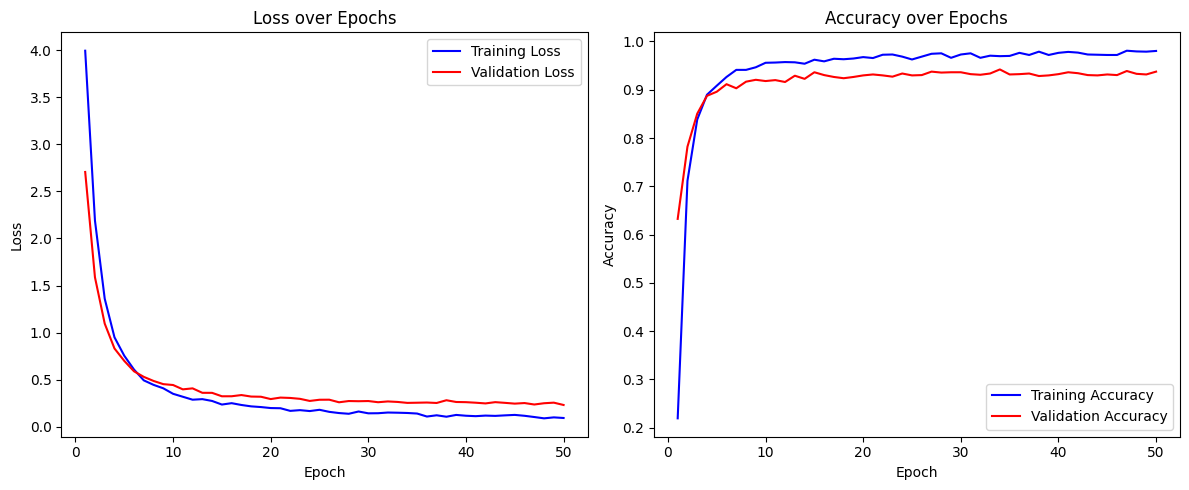

Baseline: Best Val Acc: 0.9421, Val Error: 0.0579

Training Phase 3 Configuration: Mixup
	 classifier.weight
	 classifier.bias
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 64/64 [00:12<00:00,  4.99it/s]


train Loss: 4.1662 Acc: 0.1735


Val Epoch 0: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 2.9359 Acc: 0.5075

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]


train Loss: 2.5956 Acc: 0.6225


Val Epoch 1: 100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


val Loss: 1.8351 Acc: 0.7417

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


train Loss: 1.8001 Acc: 0.7784


Val Epoch 2: 100%|██████████| 49/49 [00:10<00:00,  4.90it/s]


val Loss: 1.2477 Acc: 0.8315

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 1.4234 Acc: 0.8245


Val Epoch 3: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.9757 Acc: 0.8582

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]


train Loss: 1.1494 Acc: 0.8637


Val Epoch 4: 100%|██████████| 49/49 [00:09<00:00,  4.92it/s]


val Loss: 0.7992 Acc: 0.8855

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 1.0443 Acc: 0.8755


Val Epoch 5: 100%|██████████| 49/49 [00:09<00:00,  4.90it/s]


val Loss: 0.6878 Acc: 0.9057

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


train Loss: 0.8744 Acc: 0.8956


Val Epoch 6: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 0.6202 Acc: 0.9031

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


train Loss: 0.8289 Acc: 0.9010


Val Epoch 7: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 0.5599 Acc: 0.9141

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 0.6693 Acc: 0.9279


Val Epoch 8: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.4979 Acc: 0.9193

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.9697 Acc: 0.8990


Val Epoch 9: 100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


val Loss: 0.5729 Acc: 0.8926

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.6774 Acc: 0.9328


Val Epoch 10: 100%|██████████| 49/49 [00:09<00:00,  4.90it/s]


val Loss: 0.5009 Acc: 0.9050

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


train Loss: 0.7254 Acc: 0.9260


Val Epoch 11: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 0.4578 Acc: 0.9161

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


train Loss: 0.6722 Acc: 0.9309


Val Epoch 12: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.4387 Acc: 0.9135

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 0.7292 Acc: 0.9078


Val Epoch 13: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.4065 Acc: 0.9258

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 64/64 [00:12<00:00,  4.97it/s]


train Loss: 0.6242 Acc: 0.9279


Val Epoch 14: 100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


val Loss: 0.4317 Acc: 0.9089

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]


train Loss: 0.6752 Acc: 0.9225


Val Epoch 15: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.3959 Acc: 0.9187

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.7702 Acc: 0.9216


Val Epoch 16: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.3668 Acc: 0.9291

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.6243 Acc: 0.9431


Val Epoch 17: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 0.3603 Acc: 0.9310

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.8783 Acc: 0.9235


Val Epoch 18: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.4280 Acc: 0.9109

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 1.0088 Acc: 0.9088


Val Epoch 19: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 0.4605 Acc: 0.8966

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.5607 Acc: 0.9407


Val Epoch 20: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.3797 Acc: 0.9219

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.6192 Acc: 0.9461


Val Epoch 21: 100%|██████████| 49/49 [00:10<00:00,  4.90it/s]


val Loss: 0.3641 Acc: 0.9258

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 64/64 [00:12<00:00,  4.99it/s]


train Loss: 0.9869 Acc: 0.9093


Val Epoch 22: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 0.4142 Acc: 0.9174

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.7591 Acc: 0.9216


Val Epoch 23: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.4198 Acc: 0.9135

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.6275 Acc: 0.9358


Val Epoch 24: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 0.3382 Acc: 0.9408

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.7522 Acc: 0.9270


Val Epoch 25: 100%|██████████| 49/49 [00:09<00:00,  4.90it/s]


val Loss: 0.3975 Acc: 0.9187

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


train Loss: 0.7693 Acc: 0.9333


Val Epoch 26: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 0.3416 Acc: 0.9343

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.7092 Acc: 0.9426


Val Epoch 27: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.3593 Acc: 0.9252

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.5338 Acc: 0.9569


Val Epoch 28: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 0.3453 Acc: 0.9330

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 0.5439 Acc: 0.9338


Val Epoch 29: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.3512 Acc: 0.9258

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


train Loss: 0.7374 Acc: 0.9363


Val Epoch 30: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 0.3956 Acc: 0.9102

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.6360 Acc: 0.9382


Val Epoch 31: 100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


val Loss: 0.3802 Acc: 0.9206

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.7520 Acc: 0.9353


Val Epoch 32: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.3482 Acc: 0.9271

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 64/64 [00:12<00:00,  4.98it/s]


train Loss: 0.7475 Acc: 0.9363


Val Epoch 33: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.4021 Acc: 0.9135

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.6780 Acc: 0.9250


Val Epoch 34: 100%|██████████| 49/49 [00:09<00:00,  4.90it/s]


val Loss: 0.3666 Acc: 0.9239

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


train Loss: 0.4700 Acc: 0.9520


Val Epoch 35: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.3171 Acc: 0.9382

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 0.7278 Acc: 0.9328


Val Epoch 36: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.3506 Acc: 0.9304

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.6022 Acc: 0.9456


Val Epoch 37: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 0.3439 Acc: 0.9317

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]


train Loss: 0.7039 Acc: 0.9407


Val Epoch 38: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.3533 Acc: 0.9310

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.6733 Acc: 0.9260


Val Epoch 39: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.3731 Acc: 0.9148

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.6439 Acc: 0.9402


Val Epoch 40: 100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


val Loss: 0.3610 Acc: 0.9317

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 64/64 [00:12<00:00,  4.98it/s]


train Loss: 0.5613 Acc: 0.9539


Val Epoch 41: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 0.3424 Acc: 0.9258

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


train Loss: 0.7511 Acc: 0.9422


Val Epoch 42: 100%|██████████| 49/49 [00:10<00:00,  4.90it/s]


val Loss: 0.3776 Acc: 0.9109

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 64/64 [00:12<00:00,  4.99it/s]


train Loss: 0.7858 Acc: 0.9304


Val Epoch 43: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 0.3572 Acc: 0.9193

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


train Loss: 0.7770 Acc: 0.9279


Val Epoch 44: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 0.3808 Acc: 0.9141

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


train Loss: 0.8583 Acc: 0.9181


Val Epoch 45: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 0.3960 Acc: 0.9154

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.6184 Acc: 0.9402


Val Epoch 46: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 0.3314 Acc: 0.9278

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


train Loss: 0.6042 Acc: 0.9456


Val Epoch 47: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 0.3576 Acc: 0.9271

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


train Loss: 0.6071 Acc: 0.9436


Val Epoch 48: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 0.3667 Acc: 0.9239

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 64/64 [00:12<00:00,  4.96it/s]


train Loss: 0.5905 Acc: 0.9387


Val Epoch 49: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 0.3805 Acc: 0.9122

Training complete in 18m 60s
Best val Acc: 0.940794


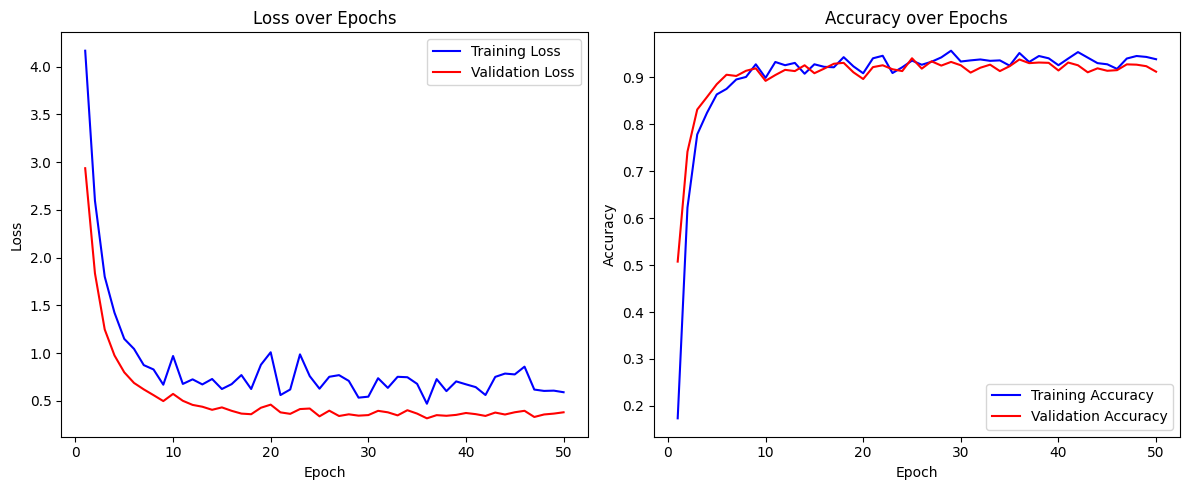

Mixup: Best Val Acc: 0.9408, Val Error: 0.0592

Training Phase 3 Configuration: Triplet Loss
	 base_model.features.conv0.weight
	 base_model.features.norm0.weight
	 base_model.features.norm0.bias
	 base_model.features.denseblock1.denselayer1.norm1.weight
	 base_model.features.denseblock1.denselayer1.norm1.bias
	 base_model.features.denseblock1.denselayer1.conv1.weight
	 base_model.features.denseblock1.denselayer1.norm2.weight
	 base_model.features.denseblock1.denselayer1.norm2.bias
	 base_model.features.denseblock1.denselayer1.conv2.weight
	 base_model.features.denseblock1.denselayer2.norm1.weight
	 base_model.features.denseblock1.denselayer2.norm1.bias
	 base_model.features.denseblock1.denselayer2.conv1.weight
	 base_model.features.denseblock1.denselayer2.norm2.weight
	 base_model.features.denseblock1.denselayer2.norm2.bias
	 base_model.features.denseblock1.denselayer2.conv2.weight
	 base_model.features.denseblock1.denselayer3.norm1.weight
	 base_model.features.denseblock1.denselayer3

Train Epoch 0: 100%|██████████| 64/64 [00:19<00:00,  3.24it/s]


train Loss: 3.6040 Acc: 0.0206


Val Epoch 0: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


val Loss: 3.3488 Acc: 0.0254

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 64/64 [00:19<00:00,  3.32it/s]


train Loss: 3.0558 Acc: 0.0240


Val Epoch 1: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 3.2649 Acc: 0.0286

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 64/64 [00:19<00:00,  3.35it/s]


train Loss: 2.6927 Acc: 0.0294


Val Epoch 2: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


val Loss: 2.5789 Acc: 0.0312

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 64/64 [00:19<00:00,  3.32it/s]


train Loss: 2.6503 Acc: 0.0333


Val Epoch 3: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 2.3561 Acc: 0.0618

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 2.4627 Acc: 0.0495


Val Epoch 4: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


val Loss: 2.2749 Acc: 0.1236

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 2.3033 Acc: 0.0667


Val Epoch 5: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


val Loss: 2.3171 Acc: 0.0794

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 2.2881 Acc: 0.0794


Val Epoch 6: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 2.3931 Acc: 0.0904

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 2.2154 Acc: 0.1039


Val Epoch 7: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


val Loss: 3.3950 Acc: 0.1373

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 2.1546 Acc: 0.1176


Val Epoch 8: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 2.0963 Acc: 0.1197

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 2.2239 Acc: 0.1196


Val Epoch 9: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 2.0766 Acc: 0.1256

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 64/64 [00:19<00:00,  3.29it/s]


train Loss: 1.9543 Acc: 0.1701


Val Epoch 10: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 2.0613 Acc: 0.1483

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 64/64 [00:19<00:00,  3.32it/s]


train Loss: 1.9606 Acc: 0.1657


Val Epoch 11: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 2.0549 Acc: 0.1529

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 64/64 [00:19<00:00,  3.32it/s]


train Loss: 1.8674 Acc: 0.1838


Val Epoch 12: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 1.9137 Acc: 0.2108

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.8633 Acc: 0.1907


Val Epoch 13: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 1.9545 Acc: 0.2154

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.7650 Acc: 0.2103


Val Epoch 14: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 2.0105 Acc: 0.2056

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 64/64 [00:19<00:00,  3.35it/s]


train Loss: 1.8492 Acc: 0.1936


Val Epoch 15: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 1.8779 Acc: 0.2095

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.7854 Acc: 0.2294


Val Epoch 16: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 1.8801 Acc: 0.2075

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.7033 Acc: 0.2387


Val Epoch 17: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 1.9135 Acc: 0.2251

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.7031 Acc: 0.2549


Val Epoch 18: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 1.7680 Acc: 0.2355

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 64/64 [00:19<00:00,  3.36it/s]


train Loss: 1.6528 Acc: 0.2873


Val Epoch 19: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 1.7298 Acc: 0.2602

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 64/64 [00:19<00:00,  3.30it/s]


train Loss: 1.6334 Acc: 0.2809


Val Epoch 20: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 1.7033 Acc: 0.2772

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.5592 Acc: 0.3289


Val Epoch 21: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 1.6263 Acc: 0.2902

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 64/64 [00:19<00:00,  3.35it/s]


train Loss: 1.4875 Acc: 0.3324


Val Epoch 22: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 1.5939 Acc: 0.3097

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 64/64 [00:19<00:00,  3.31it/s]


train Loss: 1.4740 Acc: 0.3338


Val Epoch 23: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 1.8848 Acc: 0.2700

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 64/64 [00:19<00:00,  3.31it/s]


train Loss: 1.4381 Acc: 0.3407


Val Epoch 24: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 1.5715 Acc: 0.3390

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.4177 Acc: 0.3824


Val Epoch 25: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 1.7938 Acc: 0.3435

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.4964 Acc: 0.3569


Val Epoch 26: 100%|██████████| 49/49 [00:09<00:00,  4.90it/s]


val Loss: 1.5341 Acc: 0.3253

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.3313 Acc: 0.3848


Val Epoch 27: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 1.5764 Acc: 0.3279

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.3716 Acc: 0.4025


Val Epoch 28: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 1.4780 Acc: 0.3656

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.2836 Acc: 0.4113


Val Epoch 29: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 1.5455 Acc: 0.3221

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.2574 Acc: 0.4407


Val Epoch 30: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 1.5173 Acc: 0.3416

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.1983 Acc: 0.4260


Val Epoch 31: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 1.4070 Acc: 0.3819

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.1850 Acc: 0.4426


Val Epoch 32: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 1.3110 Acc: 0.4021

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.2215 Acc: 0.4549


Val Epoch 33: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 1.4646 Acc: 0.3390

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 64/64 [00:19<00:00,  3.35it/s]


train Loss: 1.1976 Acc: 0.4569


Val Epoch 34: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


val Loss: 1.3393 Acc: 0.4340

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.1640 Acc: 0.4897


Val Epoch 35: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 1.2434 Acc: 0.4528

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 64/64 [00:19<00:00,  3.30it/s]


train Loss: 1.1897 Acc: 0.4961


Val Epoch 36: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 1.4425 Acc: 0.4060

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 64/64 [00:19<00:00,  3.36it/s]


train Loss: 1.1699 Acc: 0.4961


Val Epoch 37: 100%|██████████| 49/49 [00:09<00:00,  4.90it/s]


val Loss: 1.3823 Acc: 0.3871

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.1130 Acc: 0.4980


Val Epoch 38: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


val Loss: 1.4122 Acc: 0.4359

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.0862 Acc: 0.5137


Val Epoch 39: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 1.3628 Acc: 0.3839

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.1324 Acc: 0.5206


Val Epoch 40: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


val Loss: 1.2555 Acc: 0.4554

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 1.0344 Acc: 0.5407


Val Epoch 41: 100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


val Loss: 1.2367 Acc: 0.4548

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 64/64 [00:19<00:00,  3.32it/s]


train Loss: 1.1294 Acc: 0.5157


Val Epoch 42: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 1.1295 Acc: 0.4756

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 64/64 [00:19<00:00,  3.35it/s]


train Loss: 1.0225 Acc: 0.5319


Val Epoch 43: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


val Loss: 1.2639 Acc: 0.4281

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 64/64 [00:19<00:00,  3.35it/s]


train Loss: 1.0042 Acc: 0.5525


Val Epoch 44: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


val Loss: 1.1510 Acc: 0.4958

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 0.9909 Acc: 0.5667


Val Epoch 45: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


val Loss: 1.2387 Acc: 0.4665

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.0427 Acc: 0.5377


Val Epoch 46: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


val Loss: 1.4488 Acc: 0.4437

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 64/64 [00:19<00:00,  3.33it/s]


train Loss: 1.0153 Acc: 0.5662


Val Epoch 47: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


val Loss: 1.1156 Acc: 0.5003

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 64/64 [00:19<00:00,  3.32it/s]


train Loss: 0.9126 Acc: 0.5946


Val Epoch 48: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 1.1097 Acc: 0.5023

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]


train Loss: 0.9125 Acc: 0.6049


Val Epoch 49: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


val Loss: 1.2852 Acc: 0.4600

Training complete in 24m 28s
Best val Acc: 0.502277


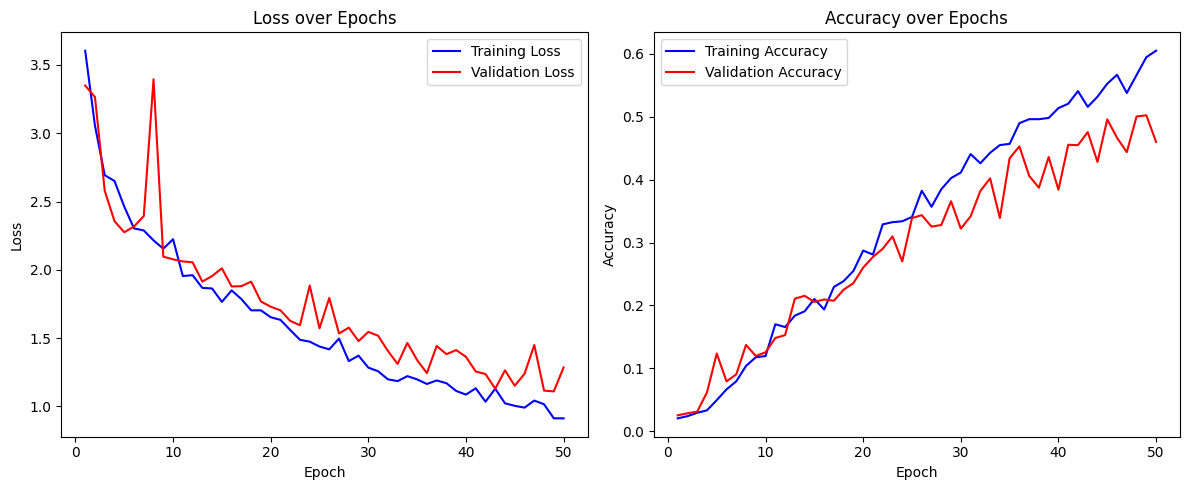

Triplet Loss: Best Val Acc: 0.5023, Val Error: 0.4977

=== Phase 3: Configuration Results ===
Baseline: Best Val Acc = 0.9421, Val Error = 0.0579
Mixup: Best Val Acc = 0.9408, Val Error = 0.0592
Triplet Loss: Best Val Acc = 0.5023, Val Error = 0.4977

Optimal Phase 3 Configuration selected: Baseline
Optimal mixup setting: False
Optimal triplet loss setting: False


In [ ]:
print("\nPhase 3: Incorporating Mixup & Triplet Loss")

# --- Prepare Datasets for Phase 3 ---
# Combine train and val splits to create the training dataset

# transform for train
flower_datasets['train'].transform = data_transforms['train']
flower_datasets['val'].transform = data_transforms['train']

# Now concatenate them
train_val_dataset = ConcatDataset([flower_datasets['train'], flower_datasets['val']])

# Split the test dataset into two halves:
# One quarter for epoch validation during training, and the other for final evaluation (Phase 4)
test_dataset = flower_datasets['test']
test_len = len(test_dataset)
quarter = test_len // 4
test_val_dataset, test_eval_dataset = random_split(
    test_dataset,
    [quarter, test_len - quarter],
    generator=generator
)

# transform the new dataset for validation and test
test_val_dataset.dataset.transform = data_transforms['val']
test_eval_dataset.dataset.transform = data_transforms['test']

# Create DataLoaders for the training and epoch-validation sets
dataloaders_phase3 = {
    "train": DataLoader(train_val_dataset, batch_size=32, shuffle=True, num_workers=0, generator=generator),
    "val": DataLoader(test_val_dataset, batch_size=32, shuffle=False, num_workers=0, generator=generator)
}

# --- Define the Three Configurations for Phase 3 ---
phase3_configs = {
    "Baseline": {"use_mixup": False, "use_tripleloss": False},
    "Mixup": {"use_mixup": True, "use_tripleloss": False},
    "Triplet Loss": {"use_mixup": False, "use_tripleloss": True},
}

phase3_results = {}
num_epochs_phase3 = num_epochs  # Adjust as needed

# Loop over each configuration
for config_name, config in phase3_configs.items():
    print(f"\nTraining Phase 3 Configuration: {config_name}")
    use_mixup = config["use_mixup"]
    use_tripleloss = config["use_tripleloss"]

    # Initialize the model using the optimal parameters from Phase 1 & 2
    model_phase3 = initialize_model(
        depth=optimal_depth,
        feature_extract=optimal_feature_extract,
        conv_type=optimal_conv_type,
        triple_loss=use_tripleloss
    )
    model_phase3 = model_phase3.to(device)

    # Setup the optimizer. (If feature extraction is enabled, only the classifier's params are updated.)
    optimizer_phase3 = get_optimiser(model=model_phase3, feature_extract=optimal_feature_extract)

    # Select the appropriate loss criterion:
    # For triplet loss, use the CombinedLoss; otherwise, standard cross-entropy.
    if use_tripleloss:
        criterion_phase3 = CombinedLoss()
    else:
        criterion_phase3 = nn.CrossEntropyLoss()

    # Train the model on the combined train+val dataset with test_val_dataset for validation
    model_phase3, hist_phase3 = train_model(
        model=model_phase3,
        dataloaders=dataloaders_phase3,
        criterion=criterion_phase3,
        optimizer=optimizer_phase3,
        num_epochs=num_epochs_phase3,
        use_mixup=use_mixup,
        use_tripleloss=use_tripleloss
    )

    # Get the best validation accuracy from the training history
    best_val_acc = max(hist_phase3[3]) if hist_phase3[3] else 0.0
    val_error = 1.0 - best_val_acc
    phase3_results[config_name] = {
        "best_val_acc": best_val_acc,
        "val_error": val_error,
        "model": model_phase3
    }
    plot_training_history(hist_phase3)
    print(f"{config_name}: Best Val Acc: {best_val_acc:.4f}, Val Error: {val_error:.4f}")

# Summarize results for each configuration
print("\n=== Phase 3: Configuration Results ===")
for config_name, result in phase3_results.items():
    print(f"{config_name}: Best Val Acc = {result['best_val_acc']:.4f}, Val Error = {result['val_error']:.4f}")

# Select the optimal configuration (lowest validation error)
optimal_phase3_config = min(phase3_results, key=lambda k: phase3_results[k]['val_error'])
print(f"\nOptimal Phase 3 Configuration selected: {optimal_phase3_config}")

# Save the optimal configuration parameters into variables for later phases
optimal_phase3_params = phase3_configs[optimal_phase3_config]
optimal_phase3_use_mixup = optimal_phase3_params["use_mixup"]
optimal_phase3_use_tripleloss = optimal_phase3_params["use_tripleloss"]

print(f"Optimal mixup setting: {optimal_phase3_use_mixup}")
print(f"Optimal triplet loss setting: {optimal_phase3_use_tripleloss}")

# Save the best model from phase 3 for further evaluation in Phase 4
best_phase3_model = phase3_results[optimal_phase3_config]["model"]


In [16]:
# --- Step 1: Create a DataLoader for the final evaluation dataset ---
flower_datasets['train'].transform = data_transforms['train']
flower_datasets['val'].transform = data_transforms['train']

# Now concatenate them
train_val_dataset = ConcatDataset([flower_datasets['train'], flower_datasets['val']])

# Split the test dataset into two halves:
# One quarter for epoch validation during training, and the other for final evaluation (Phase 4)
test_dataset = flower_datasets['test']
test_len = len(test_dataset)
quarter = test_len // 4
test_val_dataset, test_eval_dataset = random_split(
    test_dataset,
    [quarter, test_len - quarter],
    generator=generator
)

# transform the new dataset for validation and test
test_val_dataset.dataset.transform = data_transforms['val']
test_eval_dataset.dataset.transform = data_transforms['test']

dataloader_test_eval = DataLoader(
    test_eval_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    generator=generator
)

# --- Step 2: Define the evaluation function ---
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    all_top5_preds = []

    with torch.no_grad():
        dataiterator = tqdm(dataloader, desc="Evaluating", leave=True)
        for inputs, labels in dataiterator:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # If model returns a tuple (logits, embeddings) due to triplet loss, select logits
            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            # Compute predictions (for accuracy)
            _, preds = torch.max(logits, dim=1)

            # Compute top-5 predictions
            top5_vals, top5_indices = torch.topk(logits, k=5, dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())
            all_top5_preds.append(top5_indices.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    all_top5_preds = torch.cat(all_top5_preds)

    # Accuracy: overall correct predictions / total samples
    accuracy = (all_preds == all_targets).float().mean().item()

    # Top-5 accuracy: for each sample, check if true label is among top5 predictions
    total = all_targets.shape[0]
    top5_correct = sum([1 if all_targets[i].item() in all_top5_preds[i].tolist() else 0 for i in range(total)])
    top5_accuracy = top5_correct / total

    # Precision & Recall using sklearn (macro-average)
    precision = precision_score(all_targets.numpy(), all_preds.numpy(), average='macro', zero_division=0)
    recall = recall_score(all_targets.numpy(), all_preds.numpy(), average='macro', zero_division=0)

    return accuracy, top5_accuracy, precision, recall


Evaluating model for configuration: Baseline


Evaluating: 100%|██████████| 73/73 [00:29<00:00,  2.47it/s]


Baseline -- Accuracy: 0.9274, Top-5 Accuracy: 0.9859, Precision: 0.9241, Recall: 0.9337

Evaluating model for configuration: Mixup


Evaluating: 100%|██████████| 73/73 [00:29<00:00,  2.47it/s]


Mixup -- Accuracy: 0.9302, Top-5 Accuracy: 0.9876, Precision: 0.9221, Recall: 0.9378

Evaluating model for configuration: Triplet Loss


Evaluating: 100%|██████████| 73/73 [00:29<00:00,  2.48it/s]


Triplet Loss -- Accuracy: 0.5163, Top-5 Accuracy: 0.7923, Precision: 0.5476, Recall: 0.5446


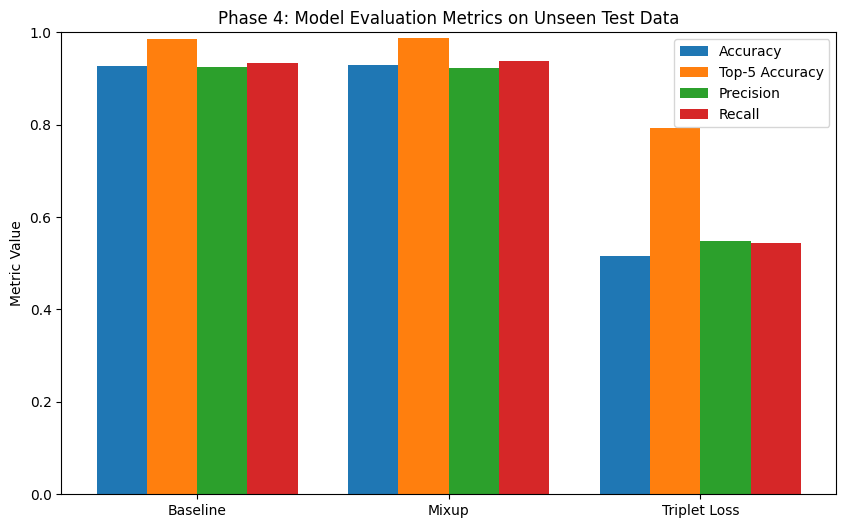

In [ ]:
# --- Step 3: Evaluate each Phase 3 model on the unseen test set ---
phase4_metrics = {}

for config_name, result in phase3_results.items():
    model = result["model"]
    print(f"\nEvaluating model for configuration: {config_name}")
    acc, top5_acc, precision, recall = evaluate_model(model, dataloader_test_eval)
    phase4_metrics[config_name] = {
        "accuracy": acc,
        "top5_accuracy": top5_acc,
        "precision": precision,
        "recall": recall
    }
    print(f"{config_name} -- Accuracy: {acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# --- Step 4: Plot the evaluation results visually ---
configs = list(phase4_metrics.keys())
accuracy_values = [phase4_metrics[c]["accuracy"] for c in configs]
top5_values = [phase4_metrics[c]["top5_accuracy"] for c in configs]
precision_values = [phase4_metrics[c]["precision"] for c in configs]
recall_values = [phase4_metrics[c]["recall"] for c in configs]

x = np.arange(len(configs))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, accuracy_values, width, label='Accuracy')
plt.bar(x - 0.5*width, top5_values, width, label='Top-5 Accuracy')
plt.bar(x + 0.5*width, precision_values, width, label='Precision')
plt.bar(x + 1.5*width, recall_values, width, label='Recall')

plt.xticks(x, configs)
plt.ylim(0, 1)
plt.ylabel('Metric Value')
plt.title('Phase 4: Model Evaluation Metrics on Unseen Test Data')
plt.legend()
plt.show()


In [ ]:
for config_name, result in phase3_results.items():
  torch.save(result["model"].state_dict(), os.path.join(models_dir, config_name+".pth"))

In [38]:
def train_model_triplet_loss(model, dataloaders, criterion, num_epochs=50, feature_extracting=False):
  """
  Trains a model that outputs (logits, embeddings). If the criterion is
  an instance of nn.TripletMarginLoss, it calls mine_triplet(embeddings, labels)
  to obtain (anchor, positive, negative) and computes loss via criterion(anchor, positive, negative).
  Otherwise (if using nn.CrossEntropyLoss), it computes loss via criterion(logits, labels).
  In the triplet loss branch, epoch accuracy is not computed/recorded.

  Additionally, based on the feature_extracting parameter:
    - If criterion is TripletMarginLoss, freeze the final classification layer.
    - If criterion is CrossEntropyLoss and feature_extracting is True, freeze all parameters except
      the final classification layer.
    - Otherwise, ensure all parameters are trainable.
  """
  if isinstance(criterion, nn.TripletMarginLoss):
    # Freeze final classification layer (assumed to be model.classifier)
    if hasattr(model, "classifier"):
      for param in model.classifier.parameters():
        param.requires_grad = False
    else:
      print("Warning: Model has no 'classifier' attribute to freeze.")
  elif isinstance(criterion, nn.CrossEntropyLoss):
    if feature_extracting:
      # Freeze all parameters first, then unfreeze the final classification layer.
      for param in model.parameters():
        param.requires_grad = False
        if hasattr(model, "classifier"):
          for param in model.classifier.parameters():
            param.requires_grad = True
        else:
          print("Warning: Model has no 'classifier' attribute to unfreeze.")
    else:
      # Ensure all parameters are trainable.
      for param in model.parameters():
        param.requires_grad = True

  optimizer = get_optimiser(model)
  early_stopper = EarlyStopper(patience=5, min_delta=0.001)
  since = time.time()

  train_loss_history = []
  train_acc_history = []  # only for cross entropy branch
  val_loss_history = []
  val_acc_history = []    # only for cross entropy branch

  best_model_wts = copy.deepcopy(model.state_dict())
  # For cross entropy, higher is better; for triplet loss, lower is better.
  if isinstance(criterion, nn.CrossEntropyLoss):
      best_metric = 0.0
  else:
    best_metric = float('inf')

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()
          else:
              model.eval()

          running_loss = 0.0
          # Only compute accuracy if using cross entropy loss
          if isinstance(criterion, nn.CrossEntropyLoss):
              running_corrects = 0

          data_iter = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch}", leave=True)
          for inputs, labels in data_iter:
              inputs = inputs.to(device)
              labels = labels.to(device)

              optimizer.zero_grad()

              # Forward pass (model returns (logits, embeddings))
              with torch.set_grad_enabled(phase == 'train'):
                  logits, embeddings = model(inputs)
                  if isinstance(criterion, nn.TripletMarginLoss):
                      # For triplet loss, use mine_triplet to get (anchor, positive, negative)
                      # (Assume mine_triplet is implemented elsewhere.)
                      anchor, positive, negative = mine_triplet(embeddings, labels)
                      if anchor is None or positive is None or negative is None:
                          loss = torch.tensor(0.0, device=device)
                      else:
                          loss = criterion(anchor, positive, negative)
                  else:
                      loss = criterion(logits, labels)
                      _, preds = torch.max(logits, 1)

              if phase == 'train':
                  loss.backward()
                  optimizer.step()

              # Accumulate loss: for CrossEntropy, multiply by batch size; for Triplet, assume loss is sum.
              if isinstance(criterion, nn.CrossEntropyLoss):
                  running_loss += loss.item() * inputs.size(0)
              else:
                  running_loss += loss.item()
              if isinstance(criterion, nn.CrossEntropyLoss):
                  running_corrects += torch.sum(preds == labels).item()

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          if isinstance(criterion, nn.CrossEntropyLoss):
              epoch_acc = running_corrects / len(dataloaders[phase].dataset)
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
          else:
              print('{} Loss: {:.4f}'.format(phase, epoch_loss))

          # Save history and best model weights (based on acc for CE and loss for triplet loss)
          if phase == 'val':
              val_loss_history.append(epoch_loss)
              if isinstance(criterion, nn.CrossEntropyLoss):
                  val_acc_history.append(epoch_acc)
                  if epoch_acc > best_metric:
                      best_metric = epoch_acc
                      best_model_wts = copy.deepcopy(model.state_dict())
              else:
                  if epoch_loss < best_metric:
                      best_metric = epoch_loss
                      best_model_wts = copy.deepcopy(model.state_dict())
          else:
              train_loss_history.append(epoch_loss)
              if isinstance(criterion, nn.CrossEntropyLoss):
                  train_acc_history.append(epoch_acc)

      print()
      # Optionally: if early_stopper.early_stop(epoch_loss): break

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  if isinstance(criterion, nn.CrossEntropyLoss):
      print('Best val Acc: {:4f}'.format(best_metric))
  else:
      print('Best val Loss: {:4f}'.format(best_metric))

  if isinstance(criterion, nn.CrossEntropyLoss):
    model.load_state_dict(best_model_wts)
  else:
      print("Using last model weights (no loading of best weights for TripletLoss)")

  if isinstance(criterion, nn.CrossEntropyLoss):
      return model, (train_loss_history, train_acc_history, val_loss_history, val_acc_history)
  else:
      return model, (train_loss_history, None, val_loss_history, None)

def mine_triplet(embeddings, labels, margin=1.0, min_triplets=64):
    """
    Mines semi-hard triplets (anchor, positive, negative) from a batch.

    First, for every possible anchor-positive pair (with the same label, excluding self),
    every negative with a different label that satisfies:

         d(anchor, positive) < d(anchor, negative) < d(anchor, positive) + margin

    is included in the output.

    If the number of triplets found is less than min_triplets, then:
      1. Repeat the search for "very-hard" negatives with condition: d(anchor, negative) < d(anchor, positive)
      2. If still not enough, repeat the search for any negative (with no distance condition).

    Args:
        embeddings (Tensor): Embeddings of shape [batch_size, embed_dim].
        labels (Tensor): Labels of shape [batch_size].
        margin (float): Margin for the semi-hard condition.
        min_triplets (int): Minimum number of triplets required (e.g. set equal to your batch size).

    Returns:
        Tuple of Tensors: (anchors, positives, negatives) containing all valid triplets,
                          or (None, None, None) if no valid triplets are found.
    """
    # Compute pairwise Euclidean distances between all embeddings.
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)

    anchors_list = []
    positives_list = []
    negatives_list = []

    N = embeddings.shape[0]
    labels_np = labels.cpu().numpy()  # for easier indexing

    # --- First search: Semi-hard negatives ---
    for i in range(N):
        for j in range(N):
            if i == j:
                continue  # skip self
            if labels_np[i] != labels_np[j]:
                continue  # not a positive pair
            d_ap = pairwise_dist[i, j]
            for k in range(N):
                if labels_np[k] == labels_np[i]:
                    continue  # negative must be a different class
                d_an = pairwise_dist[i, k]
                # Semi-hard: negative distance is greater than d_ap but within margin.
                if d_an > d_ap and d_an < d_ap + margin:
                    anchors_list.append(embeddings[i])
                    positives_list.append(embeddings[j])
                    negatives_list.append(embeddings[k])

    # If not enough triplets, search for very-hard negatives.
    if len(anchors_list) < min_triplets:
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                if labels_np[i] != labels_np[j]:
                    continue
                d_ap = pairwise_dist[i, j]
                for k in range(N):
                    if labels_np[k] == labels_np[i]:
                        continue
                    d_an = pairwise_dist[i, k]
                    # Very-hard: negative is even closer than the positive.
                    if d_an < d_ap:
                        anchors_list.append(embeddings[i])
                        positives_list.append(embeddings[j])
                        negatives_list.append(embeddings[k])

    if len(anchors_list) == 0:
        return None, None, None
    return torch.stack(anchors_list), torch.stack(positives_list), torch.stack(negatives_list)



Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 9.4600


Val Epoch 0: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 37.1256

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


train Loss: 15.0019


Val Epoch 1: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 106.3335

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


train Loss: 3.9668


Val Epoch 2: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


val Loss: 1.0394

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


train Loss: 5.5090


Val Epoch 3: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


val Loss: 5.3918

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 9.6238


Val Epoch 4: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


val Loss: 1.5460

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


train Loss: 4.2034


Val Epoch 5: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


val Loss: 1.4157

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


train Loss: 0.9145


Val Epoch 6: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


val Loss: 1.1482

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


train Loss: 7.5189


Val Epoch 7: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


val Loss: 1.3296

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


train Loss: 4.0667


Val Epoch 8: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


val Loss: 1.1799

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 4.6890


Val Epoch 9: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.0581

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


train Loss: 9.0141


Val Epoch 10: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


val Loss: 1.0212

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


train Loss: 2.2982


Val Epoch 11: 100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


val Loss: 1.3577

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 3.9540


Val Epoch 12: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


val Loss: 1.2528

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


train Loss: 3.0776


Val Epoch 13: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


val Loss: 1.3061

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


train Loss: 4.9444


Val Epoch 14: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.5416

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


train Loss: 2.1999


Val Epoch 15: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.1860

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


train Loss: 1.3654


Val Epoch 16: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.3272

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:23<00:00,  1.33it/s]


train Loss: 4.5623


Val Epoch 17: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.3878

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


train Loss: 2.4762


Val Epoch 18: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


val Loss: 1.4034

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


train Loss: 2.5133


Val Epoch 19: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.3035

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


train Loss: 1.8781


Val Epoch 20: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.2879

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


train Loss: 2.1207


Val Epoch 21: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.3402

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 4.2570


Val Epoch 22: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


val Loss: 1.4490

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


train Loss: 2.3350


Val Epoch 23: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


val Loss: 1.2770

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


train Loss: 0.9321


Val Epoch 24: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.3215

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


train Loss: 2.0085


Val Epoch 25: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.4075

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


train Loss: 2.0760


Val Epoch 26: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.1477

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


train Loss: 1.7552


Val Epoch 27: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


val Loss: 1.2333

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


train Loss: 3.0343


Val Epoch 28: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.3392

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 1.9715


Val Epoch 29: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


val Loss: 1.2043

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


train Loss: 1.3341


Val Epoch 30: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.1657

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


train Loss: 3.9603


Val Epoch 31: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.3421

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


train Loss: 1.8196


Val Epoch 32: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.3328

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 2.2173


Val Epoch 33: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.2633

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


train Loss: 2.1363


Val Epoch 34: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.2891

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:23<00:00,  1.33it/s]


train Loss: 3.5397


Val Epoch 35: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.1380

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


train Loss: 2.2624


Val Epoch 36: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.2089

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


train Loss: 1.3486


Val Epoch 37: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


val Loss: 1.2319

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


train Loss: 2.7575


Val Epoch 38: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.2902

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


train Loss: 2.9287


Val Epoch 39: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.3293

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 1.0946


Val Epoch 40: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.1687

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


train Loss: 2.8388


Val Epoch 41: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


val Loss: 1.3810

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 2.4779


Val Epoch 42: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


val Loss: 1.2933

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


train Loss: 1.6257


Val Epoch 43: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.3366

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


train Loss: 2.3428


Val Epoch 44: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.2767

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


train Loss: 1.2997


Val Epoch 45: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.3033

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


train Loss: 2.0853


Val Epoch 46: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.3004

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


train Loss: 1.8319


Val Epoch 47: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


val Loss: 1.1169

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


train Loss: 1.4067


Val Epoch 48: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


val Loss: 1.1102

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:24<00:00,  1.31it/s]


train Loss: 3.1704


Val Epoch 49: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]

val Loss: 1.2847

Training complete in 34m 33s
Best val Loss: 1.021213
Using last model weights (no loading of best weights for TripletLoss)


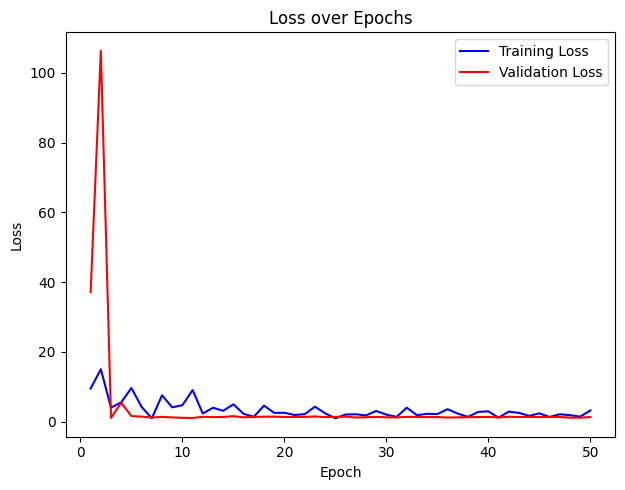


--- Training model_phase5a with Cross-Entropy Loss (Feature Extraction) ---
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 4.2331 Acc: 0.0529


Val Epoch 0: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 3.7234 Acc: 0.1197

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


train Loss: 3.5609 Acc: 0.1083


Val Epoch 1: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


val Loss: 3.5143 Acc: 0.1614

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


train Loss: 3.3749 Acc: 0.1275


Val Epoch 2: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 3.3483 Acc: 0.1535

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 3.2357 Acc: 0.1657


Val Epoch 3: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 3.3326 Acc: 0.1581

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


train Loss: 3.1766 Acc: 0.1686


Val Epoch 4: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 3.2687 Acc: 0.1893

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 3.0822 Acc: 0.1946


Val Epoch 5: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


val Loss: 3.2037 Acc: 0.1867

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 3.0817 Acc: 0.1985


Val Epoch 6: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 3.2710 Acc: 0.1913

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 3.0317 Acc: 0.2103


Val Epoch 7: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 3.1763 Acc: 0.2043

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 2.9622 Acc: 0.2255


Val Epoch 8: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


val Loss: 3.1731 Acc: 0.1991

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]


train Loss: 2.9333 Acc: 0.2225


Val Epoch 9: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 3.1138 Acc: 0.1854

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


train Loss: 2.8909 Acc: 0.2382


Val Epoch 10: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 3.0393 Acc: 0.2466

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


train Loss: 2.9138 Acc: 0.2324


Val Epoch 11: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 3.1307 Acc: 0.2277

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


train Loss: 2.8433 Acc: 0.2588


Val Epoch 12: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 3.0042 Acc: 0.2453

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


train Loss: 2.8783 Acc: 0.2250


Val Epoch 13: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 3.1281 Acc: 0.2199

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.8133 Acc: 0.2490


Val Epoch 14: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 3.0381 Acc: 0.2433

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


train Loss: 2.7893 Acc: 0.2603


Val Epoch 15: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 3.0537 Acc: 0.2583

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.7851 Acc: 0.2613


Val Epoch 16: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 3.1055 Acc: 0.2284

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


train Loss: 2.8074 Acc: 0.2686


Val Epoch 17: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


val Loss: 3.0204 Acc: 0.2381

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


train Loss: 2.7674 Acc: 0.2593


Val Epoch 18: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 2.9939 Acc: 0.2563

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.7581 Acc: 0.2598


Val Epoch 19: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 3.1341 Acc: 0.2297

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.7774 Acc: 0.2657


Val Epoch 20: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.9909 Acc: 0.2524

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


train Loss: 2.7034 Acc: 0.2843


Val Epoch 21: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


val Loss: 2.9532 Acc: 0.2635

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 2.7018 Acc: 0.2775


Val Epoch 22: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 3.0025 Acc: 0.2505

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 2.7431 Acc: 0.2858


Val Epoch 23: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 2.9615 Acc: 0.2544

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


train Loss: 2.7065 Acc: 0.2956


Val Epoch 24: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.8972 Acc: 0.2648

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 2.7476 Acc: 0.2775


Val Epoch 25: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.9163 Acc: 0.2752

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


train Loss: 2.6601 Acc: 0.2975


Val Epoch 26: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.8745 Acc: 0.2609

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


train Loss: 2.6583 Acc: 0.2926


Val Epoch 27: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.8664 Acc: 0.2707

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 2.6462 Acc: 0.3059


Val Epoch 28: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.8325 Acc: 0.2999

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.6651 Acc: 0.2902


Val Epoch 29: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.8438 Acc: 0.2609

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


train Loss: 2.6695 Acc: 0.2912


Val Epoch 30: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.9720 Acc: 0.2681

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


train Loss: 2.6576 Acc: 0.2912


Val Epoch 31: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.9423 Acc: 0.2674

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 2.6701 Acc: 0.2828


Val Epoch 32: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.9007 Acc: 0.2759

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.6292 Acc: 0.2882


Val Epoch 33: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 2.8820 Acc: 0.2752

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


train Loss: 2.6749 Acc: 0.2980


Val Epoch 34: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 2.8611 Acc: 0.2941

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.5973 Acc: 0.3078


Val Epoch 35: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 2.8728 Acc: 0.2596

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 2.5856 Acc: 0.3191


Val Epoch 36: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.8880 Acc: 0.2941

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.6242 Acc: 0.3029


Val Epoch 37: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 2.8355 Acc: 0.2980

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.6325 Acc: 0.3000


Val Epoch 38: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.8630 Acc: 0.2908

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


train Loss: 2.5896 Acc: 0.3020


Val Epoch 39: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.9666 Acc: 0.2759

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


train Loss: 2.5856 Acc: 0.3078


Val Epoch 40: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.9124 Acc: 0.2609

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


train Loss: 2.5638 Acc: 0.3078


Val Epoch 41: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 2.9069 Acc: 0.2863

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


train Loss: 2.5805 Acc: 0.3029


Val Epoch 42: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.8754 Acc: 0.3051

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 2.6292 Acc: 0.2922


Val Epoch 43: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.8612 Acc: 0.2759

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.5567 Acc: 0.3196


Val Epoch 44: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 2.8791 Acc: 0.2778

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


train Loss: 2.5918 Acc: 0.3113


Val Epoch 45: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 2.8601 Acc: 0.2843

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


train Loss: 2.5318 Acc: 0.3157


Val Epoch 46: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.8236 Acc: 0.2882

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


train Loss: 2.5779 Acc: 0.3039


Val Epoch 47: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.7676 Acc: 0.2986

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


train Loss: 2.5314 Acc: 0.3167


Val Epoch 48: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.7893 Acc: 0.3051

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


train Loss: 2.5272 Acc: 0.3353


Val Epoch 49: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.8427 Acc: 0.2986

Training complete in 18m 35s
Best val Acc: 0.305140


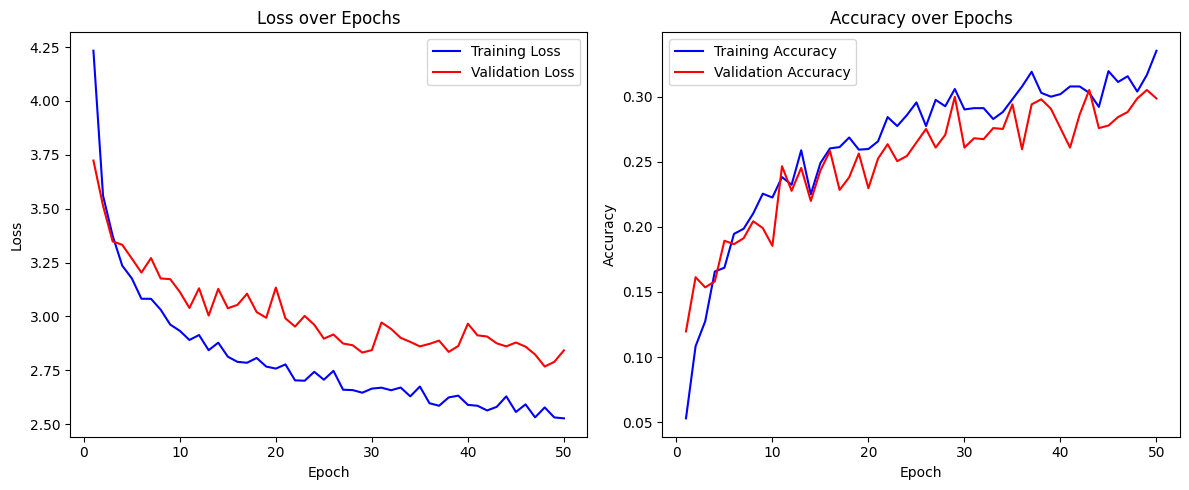


--- Training model_phase5b with Cross-Entropy Loss (Full Fine-Tuning) ---
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 4.0897 Acc: 0.0716


Val Epoch 0: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 3.6007 Acc: 0.1100

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 3.2353 Acc: 0.1627


Val Epoch 1: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 3.2361 Acc: 0.1835

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 2.8860 Acc: 0.2397


Val Epoch 2: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 2.8314 Acc: 0.2817

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 2.6353 Acc: 0.3005


Val Epoch 3: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 2.7312 Acc: 0.3032

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 2.4384 Acc: 0.3451


Val Epoch 4: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.7753 Acc: 0.3045

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 2.2157 Acc: 0.3936


Val Epoch 5: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 2.3612 Acc: 0.3767

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 2.0430 Acc: 0.4412


Val Epoch 6: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.4567 Acc: 0.3858

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 1.9129 Acc: 0.4652


Val Epoch 7: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 2.4074 Acc: 0.3826

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 1.8187 Acc: 0.4877


Val Epoch 8: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 2.2663 Acc: 0.4320

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 1.7288 Acc: 0.5201


Val Epoch 9: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


val Loss: 2.0972 Acc: 0.4587

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 1.5810 Acc: 0.5554


Val Epoch 10: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 2.0329 Acc: 0.4632

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 1.4548 Acc: 0.5961


Val Epoch 11: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 2.1633 Acc: 0.4450

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 1.3582 Acc: 0.6235


Val Epoch 12: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 2.0878 Acc: 0.4880

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 1.2626 Acc: 0.6397


Val Epoch 13: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


val Loss: 1.7961 Acc: 0.5452

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 1.1865 Acc: 0.6647


Val Epoch 14: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 1.9139 Acc: 0.5218

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 1.0817 Acc: 0.6946


Val Epoch 15: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


val Loss: 1.8777 Acc: 0.5478

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 1.0542 Acc: 0.7015


Val Epoch 16: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 1.7343 Acc: 0.5745

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 0.9869 Acc: 0.7020


Val Epoch 17: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 1.9279 Acc: 0.5192

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 0.8821 Acc: 0.7515


Val Epoch 18: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


val Loss: 1.5917 Acc: 0.5888

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 0.9024 Acc: 0.7505


Val Epoch 19: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 1.6545 Acc: 0.5823

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 0.8207 Acc: 0.7662


Val Epoch 20: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 1.6775 Acc: 0.5921

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 0.7588 Acc: 0.7873


Val Epoch 21: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 1.7490 Acc: 0.5875

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


train Loss: 0.7119 Acc: 0.8010


Val Epoch 22: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


val Loss: 1.5456 Acc: 0.6025

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 0.6495 Acc: 0.8181


Val Epoch 23: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 1.6834 Acc: 0.5953

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 0.6353 Acc: 0.8221


Val Epoch 24: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


val Loss: 1.5410 Acc: 0.6213

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 0.6585 Acc: 0.8118


Val Epoch 25: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


val Loss: 1.5504 Acc: 0.6337

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 0.5877 Acc: 0.8348


Val Epoch 26: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


val Loss: 1.4256 Acc: 0.6539

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:16<00:00,  1.88it/s]


train Loss: 0.5459 Acc: 0.8529


Val Epoch 27: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 1.6353 Acc: 0.6213

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 0.5204 Acc: 0.8515


Val Epoch 28: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 1.6000 Acc: 0.6363

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 0.4645 Acc: 0.8613


Val Epoch 29: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 1.6200 Acc: 0.6337

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 0.4907 Acc: 0.8490


Val Epoch 30: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 1.5179 Acc: 0.6370

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


train Loss: 0.4695 Acc: 0.8701


Val Epoch 31: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


val Loss: 1.5877 Acc: 0.6474

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 0.4679 Acc: 0.8554


Val Epoch 32: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 1.6766 Acc: 0.6226

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 0.4178 Acc: 0.8858


Val Epoch 33: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 1.6307 Acc: 0.6350

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 0.3909 Acc: 0.8926


Val Epoch 34: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


val Loss: 1.5359 Acc: 0.6610

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 0.4072 Acc: 0.8868


Val Epoch 35: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 1.5640 Acc: 0.6519

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]


train Loss: 0.3984 Acc: 0.8946


Val Epoch 36: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


val Loss: 1.5949 Acc: 0.6461

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 0.4043 Acc: 0.8882


Val Epoch 37: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


val Loss: 1.7828 Acc: 0.6278

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 0.3788 Acc: 0.9034


Val Epoch 38: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 1.5522 Acc: 0.6487

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 0.4033 Acc: 0.8907


Val Epoch 39: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 1.4771 Acc: 0.6740

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 0.3575 Acc: 0.9113


Val Epoch 40: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 1.5197 Acc: 0.6721

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 0.3432 Acc: 0.9103


Val Epoch 41: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


val Loss: 1.5368 Acc: 0.6662

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


train Loss: 0.3572 Acc: 0.9049


Val Epoch 42: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 1.9303 Acc: 0.6109

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


train Loss: 0.4008 Acc: 0.8922


Val Epoch 43: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


val Loss: 1.9209 Acc: 0.6135

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 0.3400 Acc: 0.8966


Val Epoch 44: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


val Loss: 1.6254 Acc: 0.6552

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


train Loss: 0.3462 Acc: 0.9074


Val Epoch 45: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


val Loss: 1.5976 Acc: 0.6617

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


train Loss: 0.3262 Acc: 0.9118


Val Epoch 46: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


val Loss: 1.6249 Acc: 0.6428

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


train Loss: 0.2395 Acc: 0.9353


Val Epoch 47: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


val Loss: 1.4880 Acc: 0.6545

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


train Loss: 0.2707 Acc: 0.9294


Val Epoch 48: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


val Loss: 1.6804 Acc: 0.6461

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


train Loss: 0.2721 Acc: 0.9240


Val Epoch 49: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


val Loss: 1.5189 Acc: 0.6662

Training complete in 22m 16s
Best val Acc: 0.674040


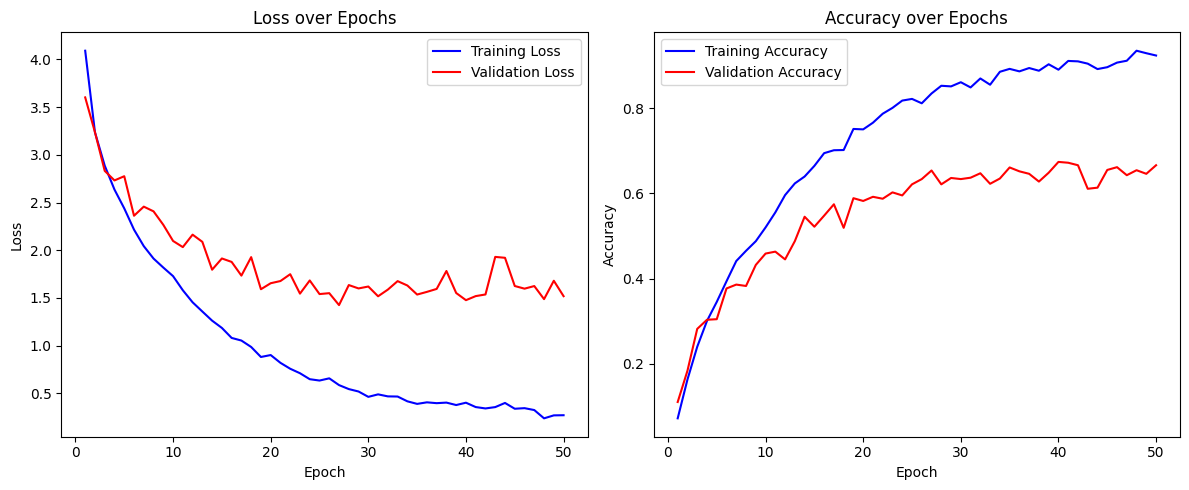


Best Validation Accuracy (model_phase5a - Feature Extraction): 0.3051
Best Validation Accuracy (model_phase5b - Full Fine-Tuning): 0.6740

--- Evaluating model_phase5a on Test Data ---


Evaluating: 100%|██████████| 73/73 [00:29<00:00,  2.44it/s]


model_phase5a -- Accuracy: 0.2730, Top-5 Accuracy: 0.5716, Precision: 0.2540, Recall: 0.3054

--- Evaluating model_phase5b on Test Data ---


Evaluating: 100%|██████████| 73/73 [00:30<00:00,  2.43it/s]

model_phase5b -- Accuracy: 0.6631, Top-5 Accuracy: 0.8667, Precision: 0.6507, Recall: 0.6858


In [40]:
# ------------------- Phase 5: Triplet Loss Sequential Training -------------------
optimal_depth = 161
optimal_conv_type = 'standard'
num_epochs_phase5 = num_epochs

# Create DataLoaders for the training and epoch-validation sets
dataloaders_phase5 = {
    "train": DataLoader(train_val_dataset, batch_size=64, shuffle=True, num_workers=0, generator=generator),
    "val": DataLoader(test_val_dataset, batch_size=64, shuffle=False, num_workers=0, generator=generator)
}

model_phase5 = initialize_model(
        depth=optimal_depth,
        conv_type=optimal_conv_type,
        triple_loss=True
    )
model_phase5 = model_phase5.to(device)


# Train the model on the combined train+val dataset with test_val_dataset for validation
model_phase5, hist_phase5 = train_model_triplet_loss(
    model=model_phase5,
    dataloaders=dataloaders_phase5,
    criterion=nn.TripletMarginLoss(reduction='sum'),
    num_epochs=num_epochs_phase5,
)
plot_training_history(hist_phase5)

# Save the current state of model_phase5 (trained with triple loss except for the final classifier)
model_phase5_state = copy.deepcopy(model_phase5.state_dict())

# -------- Experiment A: Feature Extraction (Freeze all layers except classifier) --------
print("\n--- Training model_phase5a with Cross-Entropy Loss (Feature Extraction) ---")
model_phase5a = initialize_model(
    depth=optimal_depth,
    conv_type=optimal_conv_type,
    triple_loss=True        # Use the triple-loss wrapper so forward returns (logits, embeddings)
)
# Load the trained state from model_phase5
model_phase5a.load_state_dict(model_phase5_state)
model_phase5a = model_phase5a.to(device)

model_phase5a, hist_phase5a = train_model_triplet_loss(
    model=model_phase5a,
    dataloaders=dataloaders_phase5,
    criterion=nn.CrossEntropyLoss(),  # Use cross entropy loss for fine-tuning
    num_epochs=num_epochs_phase5,
    feature_extracting=True           # Freeze all except final classifier during training
)
plot_training_history(hist_phase5a)

# -------- Experiment B: Full Fine-Tuning (All parameters trainable) --------
print("\n--- Training model_phase5b with Cross-Entropy Loss (Full Fine-Tuning) ---")
model_phase5b = initialize_model(
    depth=optimal_depth,
    conv_type=optimal_conv_type,
    triple_loss=True        # Use the triple-loss wrapper so forward returns (logits, embeddings)
)
# Load the trained state from model_phase5
model_phase5b.load_state_dict(model_phase5_state)
model_phase5b = model_phase5b.to(device)

model_phase5b, hist_phase5b = train_model_triplet_loss(
    model=model_phase5b,
    dataloaders=dataloaders_phase5,
    criterion=nn.CrossEntropyLoss(),  # Use cross entropy loss for fine-tuning
    num_epochs=num_epochs_phase5,
    feature_extracting=False          # All parameters are trainable
)
plot_training_history(hist_phase5b)

# -------- Compare Best Validation Accuracies --------
best_val_acc_a = max(hist_phase5a[3])
best_val_acc_b = max(hist_phase5b[3])

print(f"\nBest Validation Accuracy (model_phase5a - Feature Extraction): {best_val_acc_a:.4f}")
print(f"Best Validation Accuracy (model_phase5b - Full Fine-Tuning): {best_val_acc_b:.4f}")

# -------- Evaluate Models on the Test Evaluation Dataset --------

print("\n--- Evaluating model_phase5a on Test Data ---")
acc_a, top5_a, precision_a, recall_a = evaluate_model(model_phase5a, dataloader_test_eval)
print(f"model_phase5a -- Accuracy: {acc_a:.4f}, Top-5 Accuracy: {top5_a:.4f}, Precision: {precision_a:.4f}, Recall: {recall_a:.4f}")

print("\n--- Evaluating model_phase5b on Test Data ---")
acc_b, top5_b, precision_b, recall_b = evaluate_model(model_phase5b, dataloader_test_eval)
print(f"model_phase5b -- Accuracy: {acc_b:.4f}, Top-5 Accuracy: {top5_b:.4f}, Precision: {precision_b:.4f}, Recall: {recall_b:.4f}")



In [44]:
def extract_embeddings(model, dataloader):
    """
    Extract embeddings and labels from the model for a given dataloader.
    Assumes model returns (logits, embeddings).
    """
    model.eval()
    embeddings_list = []
    labels_list = []
    with torch.no_grad():
        dataiter = tqdm(dataloader, desc="Extracting embeddings", leave=True)
        for inputs, labels in dataiter:
            inputs = inputs.to(device)
            # Get the (logits, embeddings) output
            _, embeddings = model(inputs)
            embeddings_list.append(embeddings.cpu())
            labels_list.append(labels.cpu())
    embeddings_all = torch.cat(embeddings_list, dim=0)
    labels_all = torch.cat(labels_list, dim=0)
    return embeddings_all, labels_all

model_phase5.load_state_dict(model_phase5_state)
# Extract embeddings for training data
train_embeddings, train_labels = extract_embeddings(model_phase5, dataloaders_phase5["train"])

# Create a DataLoader for test_eval_dataset if not already available
test_dataloader = dataloader_test_eval
test_embeddings, test_labels = extract_embeddings(model_phase5, test_dataloader)

# Convert tensors to numpy arrays for scikit-learn
train_embeddings_np = train_embeddings.numpy()
train_labels_np = train_labels.numpy()
test_embeddings_np = test_embeddings.numpy()
test_labels_np = test_labels.numpy()

# Initialize and train the KNN classifier (adjust n_neighbors as desired)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings_np, train_labels_np)

# Predict on the test embeddings and compute accuracy
predictions = knn.predict(test_embeddings_np)
accuracy = accuracy_score(test_labels_np, predictions)
print(f"KNN Classifier Accuracy: {accuracy:.4f}")

# Compute Top-5 Accuracy using the predicted probabilities
probs = knn.predict_proba(test_embeddings_np)
# Get indices of top 5 predictions (largest probabilities) for each sample
top5_preds = np.argsort(probs, axis=1)[:, -5:]
top5_correct = 0
for i, true_label in enumerate(test_labels_np):
    if true_label in top5_preds[i]:
        top5_correct += 1
top5_accuracy = top5_correct / len(test_labels_np)
print(f"KNN Classifier Top-5 Accuracy: {top5_accuracy:.4f}")

# Compute Precision and Recall (macro-average)
precision = precision_score(test_labels_np, predictions, average='macro', zero_division=0)
recall = recall_score(test_labels_np, predictions, average='macro', zero_division=0)
print(f"KNN Classifier Precision: {precision:.4f}")
print(f"KNN Classifier Recall: {recall:.4f}")


Extracting embeddings: 100%|██████████| 73/73 [00:30<00:00,  2.43it/s]


KNN Classifier Accuracy: 0.2183
KNN Classifier Top-5 Accuracy: 0.4733
KNN Classifier Precision: 0.2194
KNN Classifier Recall: 0.2512


In [46]:
# Initialize and train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_embeddings_np, train_labels_np)

# Evaluate on the test embeddings
predictions = rf.predict(test_embeddings_np)
accuracy = accuracy_score(test_labels_np, predictions)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Compute Top-5 Accuracy using predicted probabilities
probs = rf.predict_proba(test_embeddings_np)
top5_preds = np.argsort(probs, axis=1)[:, -5:]
top5_correct = sum(1 for i, true_label in enumerate(test_labels_np) if true_label in top5_preds[i])
top5_accuracy = top5_correct / len(test_labels_np)
print(f"Random Forest Top-5 Accuracy: {top5_accuracy:.4f}")

# Compute Precision and Recall (macro-average)
precision = precision_score(test_labels_np, predictions, average='macro', zero_division=0)
recall = recall_score(test_labels_np, predictions, average='macro', zero_division=0)
print(f"Random Forest Precision: {precision:.4f}")
print(f"Random Forest Recall: {recall:.4f}")

Random Forest Accuracy: 0.3038
Random Forest Top-5 Accuracy: 0.5922
Random Forest Precision: 0.2707
Random Forest Recall: 0.3328
